<h1><b>Assignment 2 - AutoML<b></h1>

# **Dataset description**

**Dataset** - [NIFTY 50 Dataset 2000 - 2021](https://www.kaggle.com/datasets/rohanrao/nifty50-stock-market-data)

**Context**

The data is the price history and trading volumes of the fifty stocks in the index NIFTY 50 from NSE (National Stock Exchange) India. All datasets are at a day-level with pricing and trading values split across .cSV files for each stock along with a metadata file with some macro-information about the stocks itself. The data in the dataset spans from 1st January, 2000 to 30th April, 2021.


**Metadata**

Date - Trade Data: Represents the date of the trading data, indicating when the stock market activity occurred.

Symbol - Name of Stock: Refers to the unique code or symbol assigned to a particular stock. It is essentially the shorthand representation of the company's name on the stock exchange.

Series - Type of Security: Specifies the type of security, which could include different classes of financial instruments such as equity shares, preference shares, or other financial products.

Prev Close - Previous Day's Closing Price: Indicates the closing price of the stock on the previous trading day.

Open - Opening Price for the Day: Represents the initial price at which a stock is traded on a given day.

High - Highest Price for the Day: Denotes the highest trading price reached by the stock during the trading day.

Low - Lowest Price for the Day: Represents the lowest trading price reached by the stock during the trading day.

Last - Last Trade Price: Refers to the price at which the last trade was executed.

Close - Closing Price: Indicates the final trading price of the stock at the end of the trading day.

VWAP - Volume-Weighted Average Price: VWAP is a ratio of the cumulative share price to the cumulative volume traded over a given time period. It provides insight into the average price at which a stock is traded, weighted by the volume of trades.

Volume - Volume Traded for the Day: Represents the total number of shares or contracts traded during a specific time period, typically a trading day.

Turnover - Turnover Ratio: The turnover ratio is the ratio of sellers to buyers of a stock. It helps in understanding the market activity and liquidity.

Trades - Number of Trades: Indicates the total number of trades (buy and sell transactions) that occurred during the trading day.

Deliverable Volume - Amount of Deliverable Volume: Represents the volume of shares that were actually delivered (transferred) as opposed to being traded intraday.

% Deliverable - Percentage of Deliverable Shares: Indicates the percentage of shares that were delivered out of the total traded volume.

Note: All the prices are denoted in Indian Rupees (INR), as mentioned at the end of the description. This dataset provides comprehensive information about the trading activity of various stocks, allowing users to analyze and understand the market trends and stock behavior.

***The project aims to answer below questions:***
* Is the relationship significant?

* Are any model assumptions violated?

* Is there any multicollinearity in the model?

* In the multivariate models are predictor variables independent of all the other predictor variables?

* In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.

* Does the model make sense?

* Does regularization help?

* Which independent variables are significant?

* Which hyperparameters are important?

* Coding Professionalism

# <b>Installation of H2O library and importing various libraries</b>


In [1]:
!pip install h2o

In [2]:
import h2o
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from datetime import datetime
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#**Reading, cleaning the data and Plotting correlation heat map for it**

In [3]:
# Reading data from CSV
# Loading the dataset url
url = "https://raw.githubusercontent.com/Anusha-Gali/DSE_NiftyDataset/main/dataset/NIFTY50_all.csv"

#Request to read the file into the dataframe with response codes fOr validation
response = requests.get(url)
if response.status_code == 200:
  with open('NIFTY50_all.csv','wb') as file:
    file.write(response.content)
    data = pd.read_csv('NIFTY50_all.csv')
else:
  print("Failed to download the file. status_code:", response.status_code)

In [4]:
# print the the dataset
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2007-11-27,MUNDRAPORT,EQ,440.00,770.00,1050.00,770.0,959.0,962.90,984.72,27294366,2.687719e+15,NaN,9859619.0,0.3612
1,2007-11-28,MUNDRAPORT,EQ,962.90,984.00,990.00,874.0,885.0,893.90,941.38,4581338,4.312765e+14,NaN,1453278.0,0.3172
2,2007-11-29,MUNDRAPORT,EQ,893.90,909.00,914.75,841.0,887.0,884.20,888.09,5124121,4.550658e+14,NaN,1069678.0,0.2088
3,2007-11-30,MUNDRAPORT,EQ,884.20,890.00,958.00,890.0,929.0,921.55,929.17,4609762,4.283257e+14,NaN,1260913.0,0.2735
4,2007-12-03,MUNDRAPORT,EQ,921.55,939.75,995.00,922.0,980.0,969.30,965.65,2977470,2.875200e+14,NaN,816123.0,0.2741


In [5]:
# Converting the 'Symbol' and 'Series' columns to the 'category' data type
data = data.astype({'Symbol': 'category', 'Series': 'category'})

# Converting the 'Date' column to datetime format using pandas to_datetime function
data['Date'] = pd.to_datetime(data['Date'])


In [6]:
#Printing all the Unique stock names
symbol = data["Symbol"].unique()
print(symbol)
print("Unique stock values: ", len(symbol))

['MUNDRAPORT', 'ADANIPORTS', 'ASIANPAINT', 'UTIBANK', 'AXISBANK', ..., 'SSLT', 'VEDL', 'WIPRO', 'ZEETELE', 'ZEEL']
Length: 65
Categories (65, object): ['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', ..., 'VEDL', 'WIPRO',
                          'ZEEL', 'ZEETELE']
Unique stock values:  65


In [7]:
# Replacing specific values in the 'Symbol' column with corresponding replacements (done by verifying the all the .csv in the Dataset)
replace = [
    ["MUNDRAPORT", "ADANIPORTS"],
    ["UTIBANK", "AXISBANK"],
    ["BAJAUTOFIN", "BAJFINANCE"],
    ["BHARTI", "BHARTIARTL"],
    ["HEROHONDA", "HEROMOTOCO"],
    ["HINDALC0", "HINDALCO"],
    ["HINDLEVER", "HINDUNILVR"],
    ["INFOSYSTCH", "INFY"],
    ["JSWSTL", "JSWSTEEL"],
    ["KOTAKMAH", "KOTAKBANK"],
    ["TELCO", "TATAMOTORS"],
    ["TISCO", "TATASTEEL"],
    ["UNIPHOS", "UPL"],
    ["SESAGOA", "VEDL"],
    ["SSLT", "VEDL"],
    ["ZEETELE", "ZEEL"]
]

# Iterating through the 'replace' list and replacing the values in the 'Symbol' column and then displaying the unique values
for replacement in replace:
    data.loc[data["Symbol"] == replacement[0], "Symbol"] = replacement[1]
print(data["Symbol"].unique())


['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV', ..., 'ULTRACEMCO', 'UPL', 'VEDL', 'WIPRO', 'ZEEL']
Length: 49
Categories (65, object): ['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', ..., 'VEDL', 'WIPRO',
                          'ZEEL', 'ZEETELE']


In [8]:
# finding null values if any to replace them
data.isnull().sum()

Date                       0
Symbol                     0
Series                     0
Prev Close                 0
Open                       0
High                       0
Low                        0
Last                       0
Close                      0
VWAP                       0
Volume                     0
Turnover                   0
Trades                114848
Deliverable Volume     16077
%Deliverble            16077
dtype: int64

In [9]:
# replacing null values with 0 based on the above explanation
data["Trades"].fillna(0, inplace = True)
data["Deliverable Volume"].fillna(0, inplace = True)
data["%Deliverble"].fillna(0, inplace = True)

In [10]:
# checking if there is still any null values
data.isnull().sum()

Date                  0
Symbol                0
Series                0
Prev Close            0
Open                  0
High                  0
Low                   0
Last                  0
Close                 0
VWAP                  0
Volume                0
Turnover              0
Trades                0
Deliverable Volume    0
%Deliverble           0
dtype: int64

<ipython-input-11-12dd92382f8e>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot = True, cmap = "RdYlGn")


<Axes: >

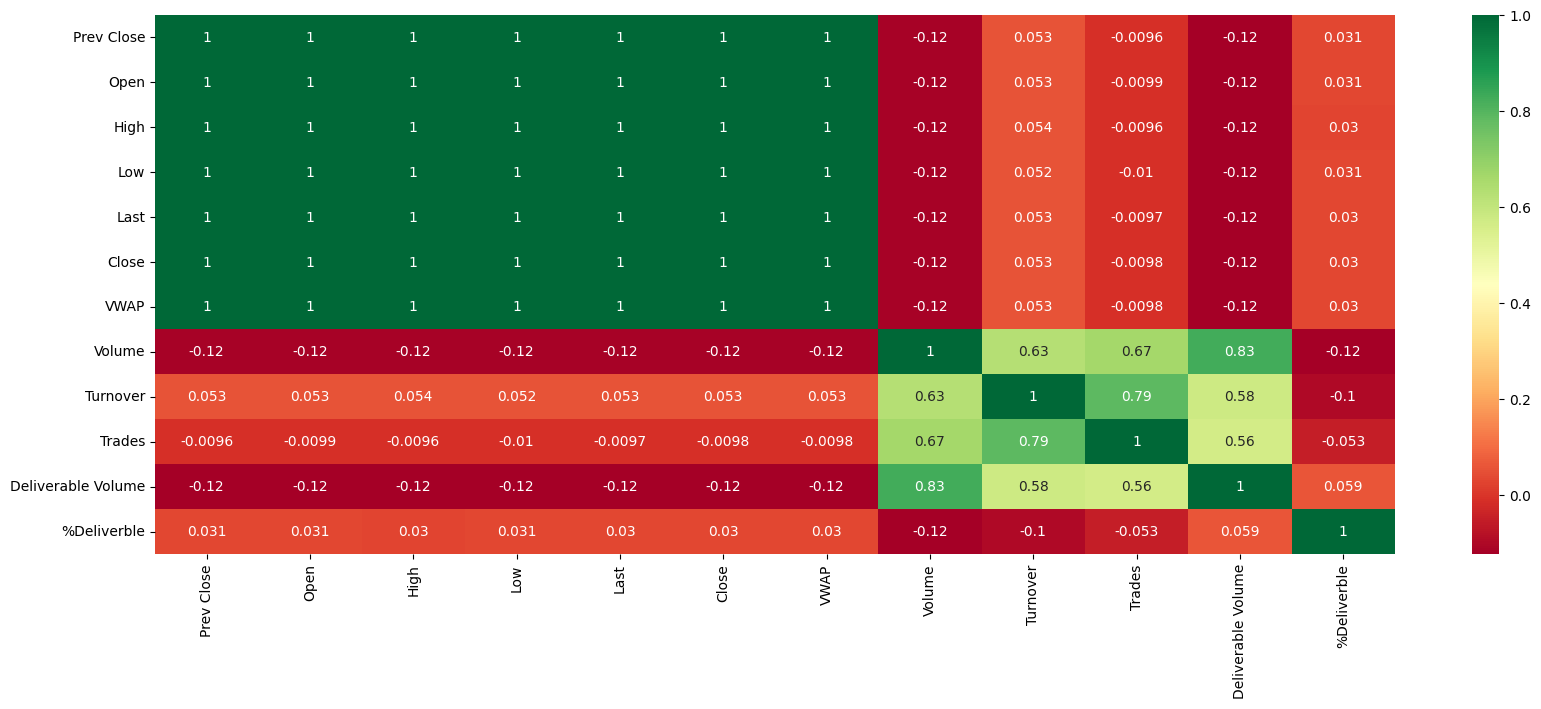

In [11]:
# Setting the size of the heatmap figure
plt.figure(figsize=(20, 7))

# Creating a heatmap of the correlation matrix for the dataset and using cmap="RdYlGn" for better visualization
sns.heatmap(data.corr(), annot = True, cmap = "RdYlGn")

#**H2O Initialization**

In [12]:
#Connecting to a cluster or initialize it if not started
h2o.init(strict_version_check=False)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpx6hlh08e
  JVM stdout: /tmp/tmpx6hlh08e/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpx6hlh08e/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,1 month and 30 days
H2O_cluster_name:,H2O_from_python_unknownUser_ilawoz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [13]:
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)

In [14]:
#Importing dataset with H2O
h2o_data = h2o.H2OFrame(data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
h2o_data.types

{'Date': 'time',
 'Symbol': 'enum',
 'Series': 'enum',
 'Prev Close': 'real',
 'Open': 'real',
 'High': 'real',
 'Low': 'real',
 'Last': 'real',
 'Close': 'real',
 'VWAP': 'real',
 'Volume': 'int',
 'Turnover': 'real',
 'Trades': 'int',
 'Deliverable Volume': 'int',
 '%Deliverble': 'real'}

In [16]:
h2o_data.isna().sum()

0.0

In [17]:
# train/test split
train, valid, test = h2o_data.split_frame(
    ratios=[0.7, 0.1], # train:validate:test = 0.7:0.1:0.2
    destination_frames=["train", "valid", "test"],
    seed=1234
)

# Summary of the split
print("Training set:", train.shape)
print("Validation set:", valid.shape)
print("Test set:", test.shape)

Training set: (164729, 15)
Validation set: (23500, 15)
Test set: (46963, 15)


In [18]:
# Seperating the dependent and independent variables
y ='Close'
X= [ i for i in h2o_data.columns if i not in ['Date', 'Symbol', "Series", 'Close']]

print("Dependent Variable: ", y)
print("Independent Variable: ", X)

Dependent Variable:  Close
Independent Variable:  ['Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']


In [19]:
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", max_runtime_secs=600)
aml.train(x=X, y=y, training_frame=train, validation_frame=valid, leaderboard_frame=test)

AutoML progress: |
03:47:37.868: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20240220_34737


Model Summary: 
    number_of_trees
--  -----------------
    94

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 34.02816884552317
RMSE: 5.833366853329488
MAE: 2.5680382112433198
RMSLE: 0.003893429928984216
Mean Residual Deviance: 34.02816884552317

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 245.1294946693974
RMSE: 15.656611851527693
MAE: 4.044030280458166
RMSLE: 0.004749130822290599
Mean Residual Deviance: 245.1294946693974

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 305.70966834105513
RMSE: 17.484555137064685
MAE: 4.201754089560504
RMSLE: 0.004788417406377119
Mean Residual Deviance: 305.70966834105513

Cross-Validation Metrics Summary: 
                        mean        sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     4.20176     0.209358     4.17511       4.05148       4.21524       4.02032       4.54662
mean_residual_deviance  305.71      31.8246      316.735       283.828       336.355       261.787       329.844
mse                     305.71      31.8246      316.735       283.828       336.355       261.787       329.844
r2                      0.999954    4.73092e-06  0.999953      0.999957      0.99995       0.999961      0.99995
residual_deviance       305.71      31.8246      316.735       283.828       336.355       261.787       329.844
rmse                    17.4651     0.921209     17.797        16.8472       18.34         16.1798       18.1616
rmsle                   0.00478559  0.000183869  0.00472248    0.00463973    0.00475568    0.00470436    0.00510572

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance    validation_rmse    validation_mae    validation_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------  -----------------  ----------------  ---------------------
    2024-02-20 03:54:15  6 min 37.955 sec  0                  2876.15          1266.71         8.27226e+06          2937.68            1277.76           8.62994e+06
    2024-02-20 03:54:17  6 min 39.678 sec  5                  490.957          213.78          241038               505.173            216.164           255199
    2024-02-20 03:54:19  6 min 41.310 sec  10                 87.7898          36.2088         7707.04              92.5022            36.9379           8556.66
    2024-02-20 03:54:21  6 min 43.572 sec  15                 21.9139          7.06984         480.218              26.1585            7.61746           684.269
    2024-02-20 03:54:25  6 min 47.082 sec  20                 13.039           3.56453         170.015              18.1586            4.39456           329.736
    2024-02-20 03:54:28  6 min 50.444 sec  25                 11.0958          3.21665         123.117              16.8321            4.14399           283.319
    2024-02-20 03:54:30  6 min 52.930 sec  30                 10.0858          3.10992         101.723              16.5187            4.10231           272.866
    2024-02-20 03:54:33  6 min 55.451 sec  35                 9.25533          3.0244          85.6611              16.0086            4.06094           256.274
    2024-02-20 03:54:36  6 min 58.070 sec  40                 8.68373          2.96157         75.4072              15.9118            4.06823           253.185
    2024-02-20 03:54:40  7 min  2.619 sec  45                 8.30992          2.91848         69.0548              15.9244            4.06722           253.585
    2024-02-20 03:54:43  7 min  5.486 sec  50                 7.89977          2.86828         62.4063              15.8644            4.05962           

In [20]:
# Viewing all the models
leaderboard = aml.leaderboard
leaderboard.head()

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
XGBoost_1_AutoML_1_20240220_34737,4.16749,16.815,282.745,0.00469232,282.745
GLM_1_AutoML_1_20240220_34737,1186.13,2549.52,6.50005e+06,1.39354,6.50005e+06


## Parameters
* **Mean Squared Error (MSE)**: -> Smaller the value better the model (ranges from zero to infinity)

defination:
The MSE measures the average squared difference between the predicted and actual values. It is calculated by taking the average of the squared differences between the predicted and actual values. It is a common metric for evaluating the accuracy of regression models.



* **Root Mean Squared Error (RMSE)**: -> Smaller the value better the model (ranges from zero to infinity)

defination:
The RMSE is the square root of the MSE, and it is a commonly used metric for evaluating the accuracy of regression models. The RMSE is a measure of how well the model is able to predict the actual values.

* **Mean Absolute Error (MAE**): -> Smaller the value better the model (ranges from zero to infinity)

defination:
The MAE measures the average absolute difference between the predicted and actual values. It is calculated by taking the average of the absolute differences between the predicted and actual values. It is a common metric for evaluating the accuracy of regression models.

* **Root Mean Squared Logarithmic Error (RMSLE)**: -> Smaller the value better the model (ranges from zero to infinity). The RMSLE evaluation metric is returned only if all label and predicted values are non-negative.

defination:
The RMSLE is a variation of the RMSE that is used for regression models where the target variable has a wide range of values. It is calculated by taking the square root of the average of the squared differences between the logarithm of the predicted and actual values.

* **Mean Residual Deviance**:

defination:
The Mean Residual Deviance is a measure of the goodness of fit for a regression model. It measures the average difference between the predicted and actual values, normalized by the degrees of freedom of the model.

* **R-squared (R^2)**: -> Value closer to 1.0 better the accuracy (ranges from zero and one)

defination:
The R-squared is a measure of how well the model fits the data. It is the proportion of the variance in the dependent variable that is explained by the independent variables. A value of 1 means that the model explains all the variability in the data, while a value of 0 means that the model explains none of the variability.

In [21]:
# model 2 -> GLM
l_df = leaderboard.as_data_frame()
second_model_id = l_df.at[1,"model_id"]
second_model = h2o.get_model(second_model_id)
print(second_model)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_1_20240220_34737


GLM Model: summary
    family    link      regularization              lambda_search                                                                     number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------  --------------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  --------------------------------------
    gaussian  identity  Ridge ( lambda = 61843.0 )  nlambda = 30, lambda.max = 258220.0, lambda.min = 61843.0, lambda.1se = 258220.0  11                            11                             4                       AutoML_1_20240220_34737_training_train

ModelMetricsRegres

## Observations on the (Model 2)

* H2OGeneralizedLinearEstimator which is Generalized Linear Modeling
* GLM_1_AutoML_1_20240219_20838, a unique identifier for this model..

#### for Cross-Validation Metrics Summary:

* The Mean Squared Error (MSE) of 6.67, a measure of the model's accuracy, with lower values indicating better performance, suggests that the model's predictions are, on average, relatively close to the actual values.
* The Mean Absolute Error (MAE) of 1194.74, a measure of the average prediction error, also indicates a low average error in predictions, supporting the inference from the MSE.
* The mean value of R-squared (r2) is close to zero, indicating that the model explains very little of the variance in the target variable. This contradicts the initial assessment and suggests that the model might not be performing as well as initially thought.



In [22]:
# model 1 -> XGBoost
l_df = leaderboard.as_data_frame()
first_model_id = l_df.at[0,"model_id"]
first_model = h2o.get_model(first_model_id)
print(first_model)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20240220_34737


Model Summary: 
    number_of_trees
--  -----------------
    94

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 34.02816884552317
RMSE: 5.833366853329488
MAE: 2.5680382112433198
RMSLE: 0.003893429928984216
Mean Residual Deviance: 34.02816884552317

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 245.1294946693974
RMSE: 15.656611851527693
MAE: 4.044030280458166
RMSLE: 0.004749130822290599
Mean Residual Deviance: 245.1294946693974

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 305.70966834105513
RMSE: 17.484555137064685
MAE: 4.201754089560504
RMSLE: 0.004788417406377119
Mean Residual Deviance: 305.70966834105513

Cross-Validation Metrics Summary: 
                        mean        sd           cv_1_valid    cv_2_valid    cv_

## Observations on the (Model 1)

* H2OXGBoostEstimator, which is a XGBoost.
* XGBoost_1_AutoML_1_20240219_20838, a unique identifier for this model..

#### for Cross-Validation Metrics Summary:

* The Mean Squared Error (MSE) of 305.71, a measure of the model's accuracy, suggests that the model's predictions are relatively close to the actual values on average.
* The Mean Absolute Error (MAE) of 4.20176 indicates a low average prediction error, supporting the inference from the MSE.
* The mean value of R-squared (r2) being close to 1.0 suggests that the model explains most of the variance in the target variable, indicating a good fit.

##Comparing with Model 1:

The MSE and MAE values in Model 2 are higher, indicating that Model 1 might have better predictive performance in terms of accuracy and average error.
The R-squared value in Model 1 was also very close to 1.0, suggesting a strong fit, similar to Model 2.
Overall, while both models show strong performance, Model 1 might have a slight edge in terms of predictive accuracy and error metrics.

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
XGBoost_1_AutoML_1_20240220_34737,16.815,282.745,4.16749,0.00469232,282.745,63146,0.014746,XGBoost
GLM_1_AutoML_1_20240220_34737,2549.52,6.50005e+06,1186.13,1.39354,6.50005e+06,376,0.000667,GLM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

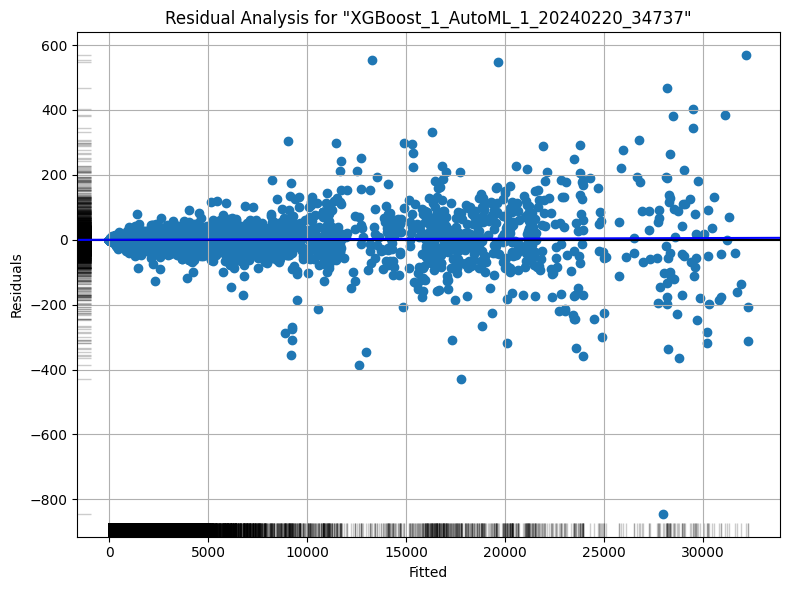

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

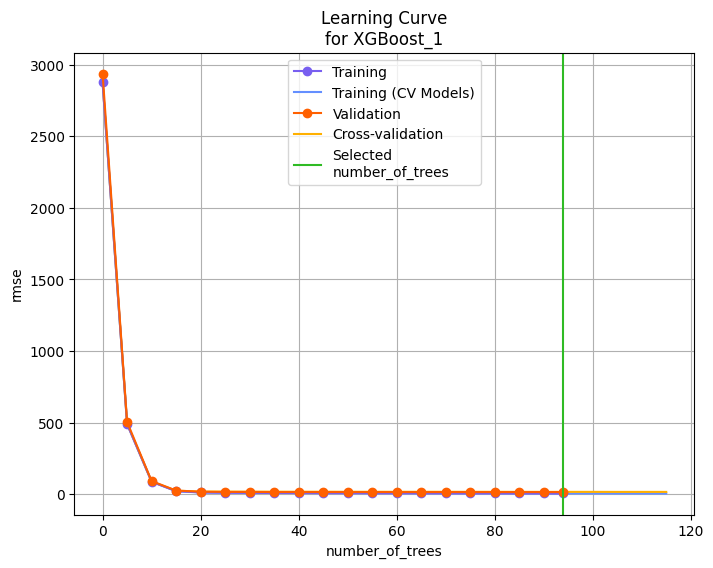

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

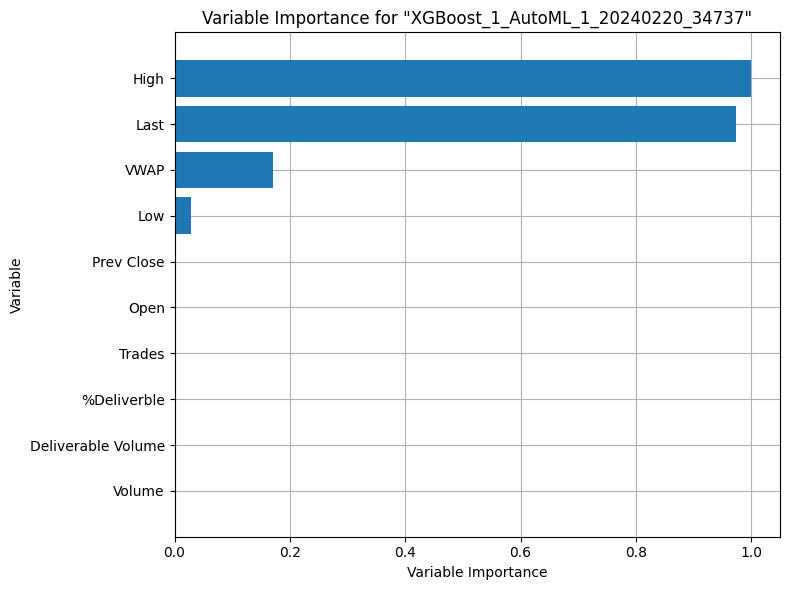

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

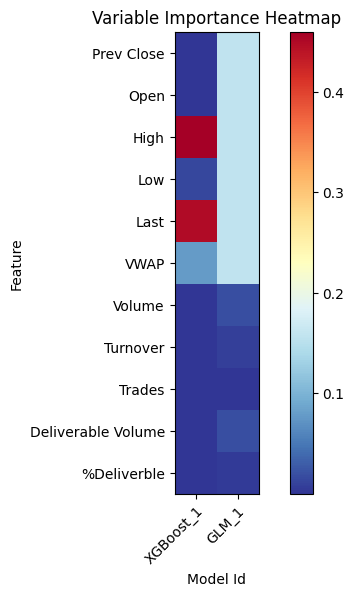

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

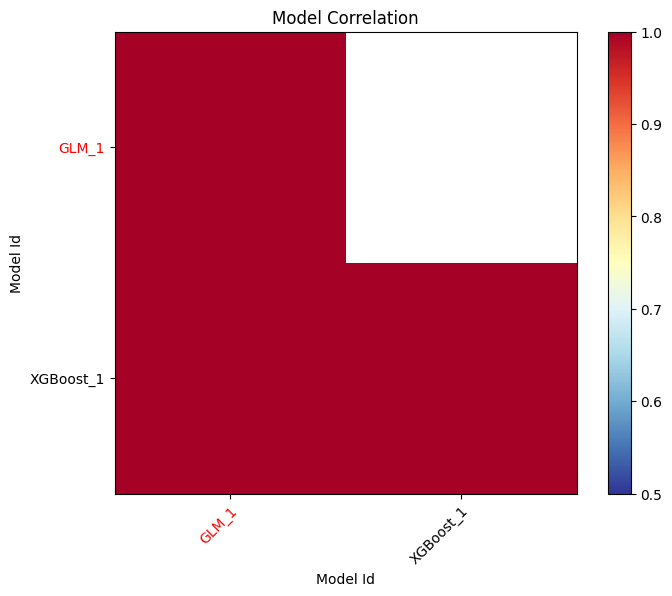

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

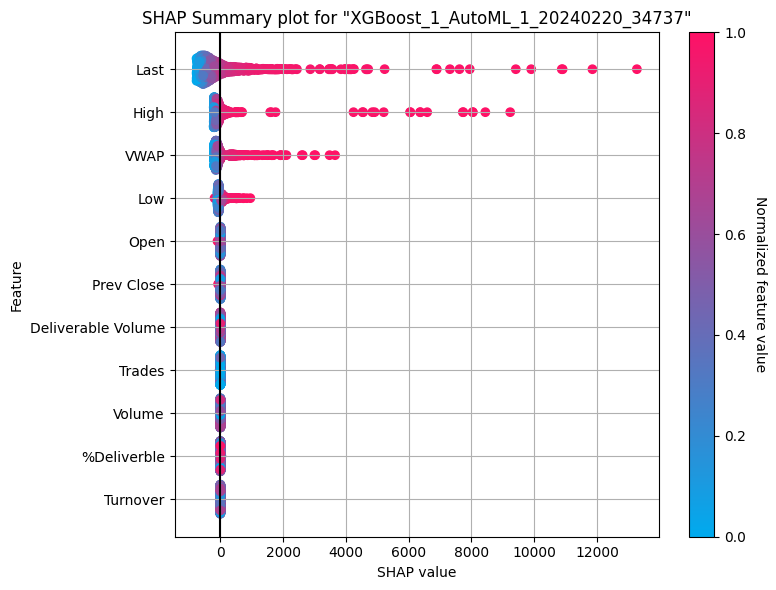

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

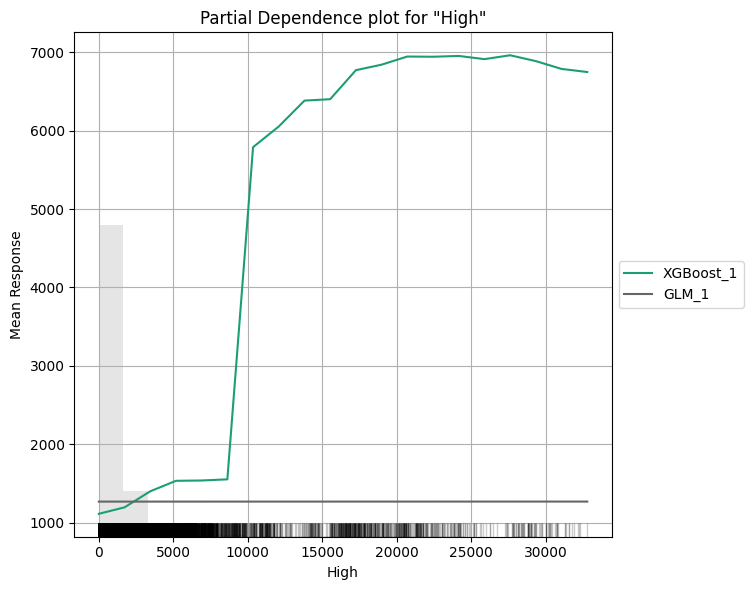

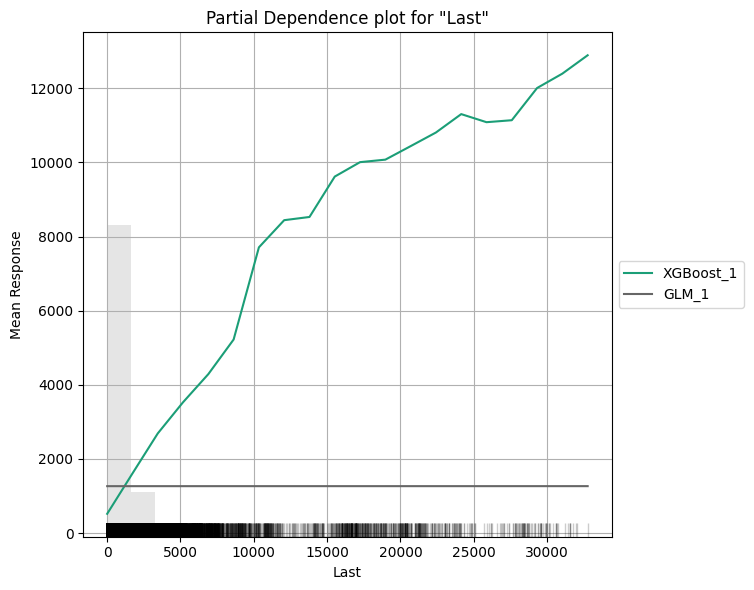

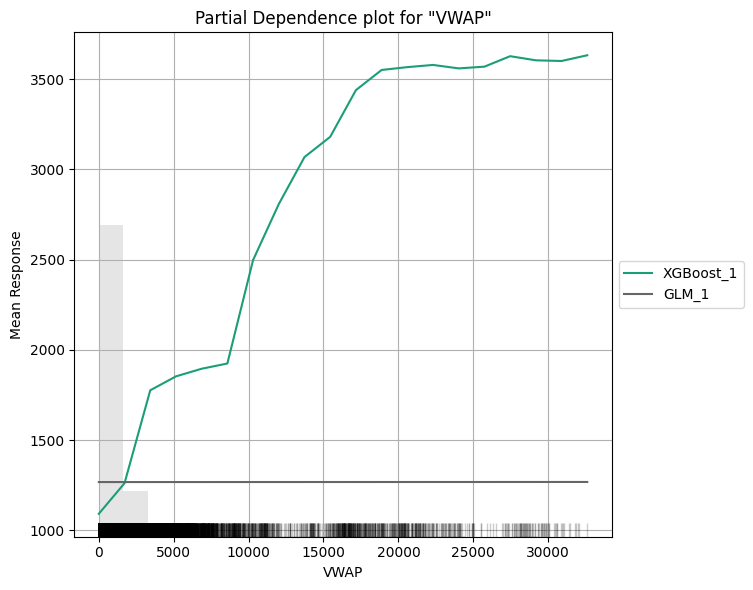

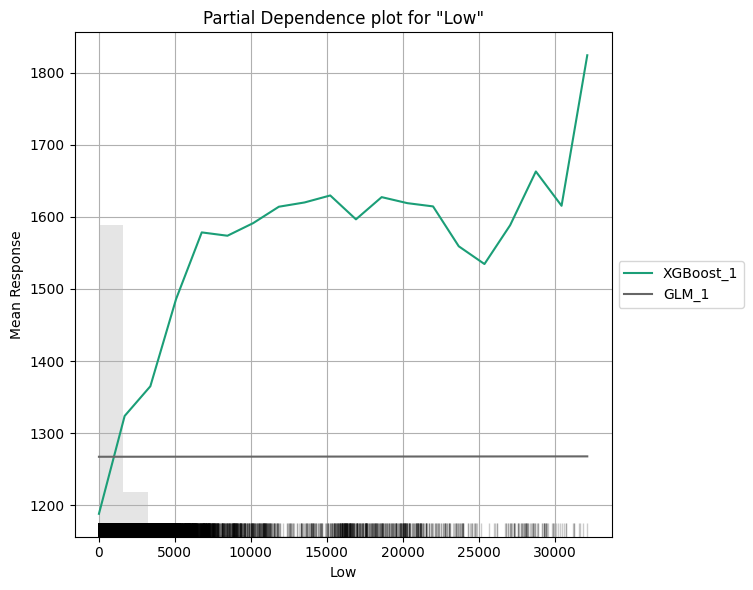

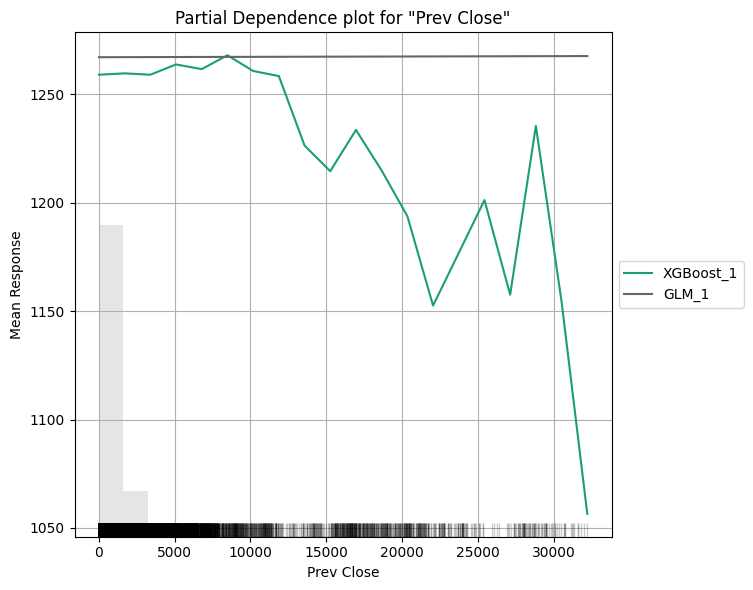

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

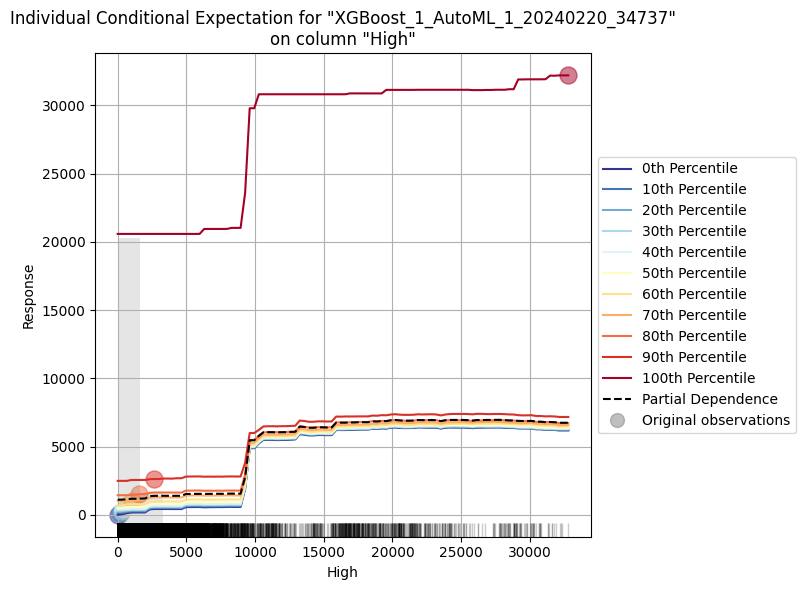

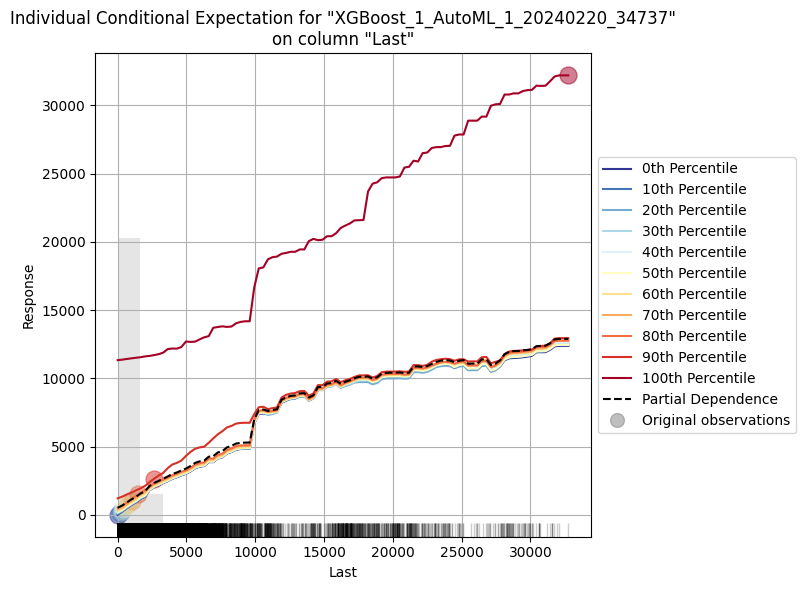

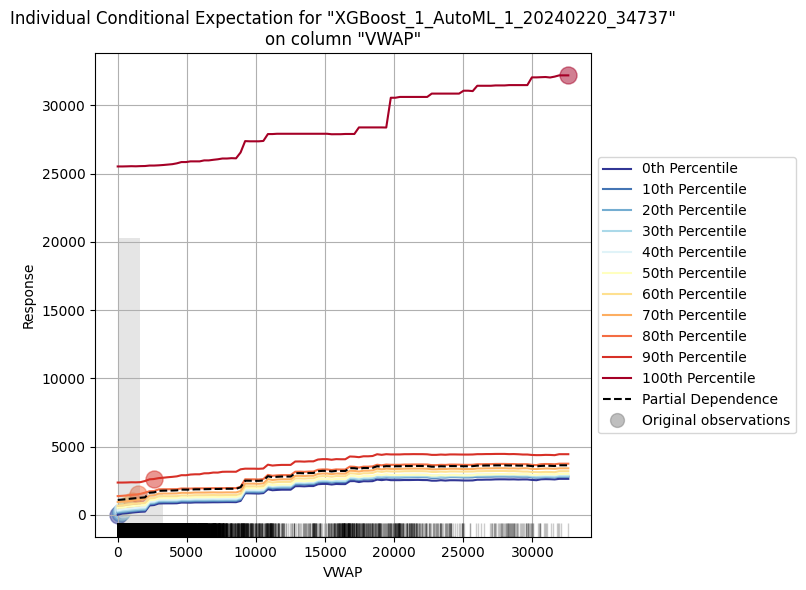

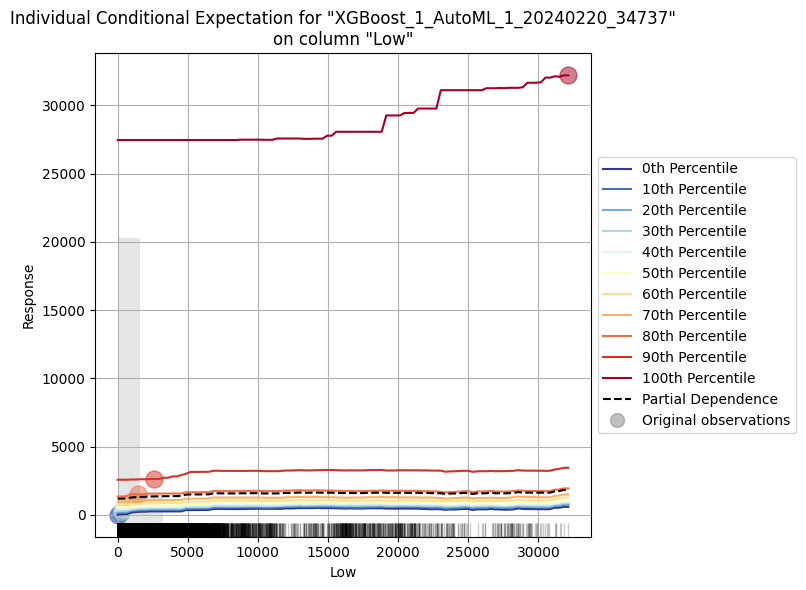

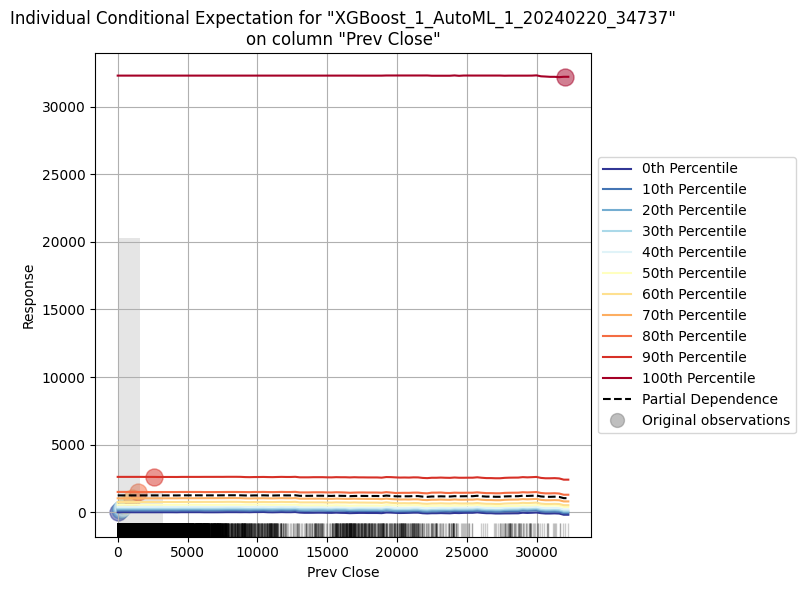

In [23]:
explain_model = aml.explain(frame = test, figsize = (8,6))

## **Residual Analysis**:
From the above plot we can obser that Most of the points are scattered randomly around 0 (the horizontal line at y = 0) indicating a well fit model.


## **Learning Curve Plot**:
There is a small gap between training and validation indicating a good fit (no over/under fitting)


## **Variable Importance**:
**Last**: have highest impact on the prediction outcome. This
suggests that the Last plays a significant role in determining the Close price

**High and VWAP**: have moderate impact on the prediction outcome.

**Low and Open**: have low impact on the prediction outcome.

## **Variable Importance Heatmap**:
From the Diagram we can observe that the models are highly impacted by **Last**, **High** to predict the closing price.(XGBoost)

## **SHAP Summary**:
We can observe that **Last** has the most impact. **VWAP and High** have moderate impact. **Low** has low impact.

## **Partial Dependence Plots**:
This plot also shows how **Last and High**  has positive and high Impact.**VWAP and Low** have positive but Moderate impact. **Prev Close** have positive but low impact.

## **Individual Conditional Expectation**:
This plot supports the observations of the previous plots.

In [24]:
# getting the VIF values and indicating on which variables to compute VIF
Multic = data[['Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']]

#Compute VIF
vif = pd.DataFrame()

vif["variables"] = Multic.columns

vif["VIF"] = [variance_inflation_factor(Multic.values, i) for i in range(Multic.shape[1])]
vif

,variables,VIF
0,Prev Close,1797.754488
1,Open,9588.564654
2,High,19036.615693
3,Low,17565.226566
4,Last,12831.087806
5,VWAP,51987.824721
6,Volume,4.046238
7,Turnover,3.650568
8,Trades,3.067513
9,Deliverable Volume,3.463659


VIF for "Prev Close", "Open", "High", "Low", "Last", "VWAP" are greater than 10 that means they are multicollinearity.

# Re-executing AutoML with reduced columns


Removing - ['Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble']

In [25]:
ml_data=data.drop(['Date', "Symbol", "Series", 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble'], axis=1)

In [26]:
# Converting dataframe to H2OFrame
hf = h2o.H2OFrame(ml_data)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [27]:
hf.head()

Prev Close,Open,High,Low,Last,Close,VWAP
440,770,1050,770,959,962.9,984.72
962.9,984,990,874,885,893.9,941.38
893.9,909,914.75,841,887,884.2,888.09
884.2,890,958,890,929,921.55,929.17
921.55,939.75,995,922,980,969.3,965.65
969.3,985,1056,976,1049,1041.45,1015.39
1041.45,1061,1099.5,1050,1084,1082.45,1082.79
1082.45,1089,1109.7,1051,1090.1,1081.3,1087.03
1081.3,1100,1134,1078,1100,1102.4,1106.57
1102.4,1110,1110,1061.1,1073.55,1075.4,1080.38


In [28]:
# train/test data split
train1, valid1, test1 = hf.split_frame(
    ratios=[0.7, 0.1], # train:validate:test = 0.7:0.1:0.2
    destination_frames=["train", "valid", "test"],
    seed=1234
)

# Summary of the split
print("Training set:", train1.shape)
print("Validation set:", valid1.shape)
print("Test set:", test1.shape)

Training set: (164729, 7)
Validation set: (23500, 7)
Test set: (46963, 7)


In [29]:
# Seperating the dependent and independent variables
y1 ='Close'
X1 = [ i for i in hf.columns if i not in ['Close']]

print("Dependent Variable: ", y1)
print("Independent Variable: ", X1)

Dependent Variable:  Close
Independent Variable:  ['Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP']


In [30]:
# Run AutoML for 10 base models (limited to 1 hour max runtime by default)
aml1 = H2OAutoML(max_models=10, seed=1234, sort_metric="MAE", max_runtime_secs=600)
aml1.train(x=X1, y=y1, training_frame=train1, validation_frame=valid1, leaderboard_frame=test1)

AutoML progress: |
04:03:20.323: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_2_20240220_40320


Model Summary: 
    number_of_trees
--  -----------------
    133

ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 35.50972056541543
RMSE: 5.95900331980235
MAE: 2.564876752586076
RMSLE: 0.003887965321571827
Mean Residual Deviance: 35.50972056541543

ModelMetricsRegression: xgboost
** Reported on validation data. **

MSE: 211.28722567759158
RMSE: 14.53572239957793
MAE: 3.924136479966184
RMSLE: 0.004765264985117067
Mean Residual Deviance: 211.28722567759158

ModelMetricsRegression: xgboost
** Reported on cross-validation data. **

MSE: 268.7303558600202
RMSE: 16.39299715915367
MAE: 4.088329202235271
RMSLE: 0.0047454763352603345
Mean Residual Deviance: 268.7303558600202

Cross-Validation Metrics Summary: 
                        mean        sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     4.08833     0.11395      4.10251       4.03045       4.04498       3.9857        4.278
mean_residual_deviance  268.73      24.2996      287.763       258.173       286.699       230.854       280.163
mse                     268.73      24.2996      287.763       258.173       286.699       230.854       280.163
r2                      0.99996     3.61269e-06  0.999957      0.999961      0.999957      0.999965      0.999958
residual_deviance       268.73      24.2996      287.763       258.173       286.699       230.854       280.163
rmse                    16.3791     0.754661     16.9636       16.0678       16.9322       15.1939       16.7381
rmsle                   0.00474216  0.000198363  0.00458171    0.00467034    0.00472137    0.00465186    0.00508553

Scoring History: 
     timestamp            duration          number_of_trees    training_rmse       training_mae        training_deviance    validation_rmse     validation_mae      validation_deviance
---  -------------------  ----------------  -----------------  ------------------  ------------------  -------------------  ------------------  ------------------  ---------------------
     2024-02-20 04:11:28  8 min  8.156 sec  0.0                2876.1529912253486  1266.7071304076862  8272256.02893452     2937.6765594963213  1277.7633302772197  8629943.568214143
     2024-02-20 04:11:29  8 min  9.306 sec  5.0                491.04065469182257  213.84917514733453  241120.9245601737    505.1081847587771   216.0978365623393   255134.27831030692
     2024-02-20 04:11:30  8 min 10.399 sec  10.0               87.57049704121904   36.221260261536806  7668.591952046152    91.62169549623565   36.70891705038193   8394.535085604926
     2024-02-20 04:11:32  8 min 12.033 sec  15.0               21.199003048550523  7.035101656234116   449.3977302524544    24.50964659728988   7.445165290548446   600.7227763240434
     2024-02-20 04:11:34  8 min 13.830 sec  20.0               12.426218247734676  3.5311494720839045  154.41089994033425   17.15871171145849   4.319501682687313   294.42138759694274
     2024-02-20 04:11:37  8 min 16.783 sec  25.0               10.944740172265545  3.2055097721366788  119.78733743840323   15.876561877597204  4.068313491699543   252.06521705317286
     2024-02-20 04:11:39  8 min 19.184 sec  30.0               10.409739276706913  3.141993396835615   108.36267180901456   15.439752154289799  4.0285060393962455  238.38594658589648
     2024-02-20 04:11:41  8 min 21.116 sec  35.0               9.744059248017843   3.069625675525921   94.94669062888204    15.17873688284241   3.998316312059443   230.3940533585605
     2024-02-20 04:11:43  8 min 23.079 sec  40.0               9.43242163669107    3.0421558475917587  88.97057793231782    15.243248795396491  3.996706226389459   232.35663383835657
     2024-02-20 04:11:45  8 min 25.277 sec  45.0               8.979497272496118   2.993225322236828   8

In [31]:
# Viewing all models
leaderboard1 = aml1.leaderboard
leaderboard1.head()

model_id,mae,rmse,mse,rmsle,mean_residual_deviance
XGBoost_1_AutoML_2_20240220_40320,3.81577,13.54,183.331,0.00457105,183.331
GLM_1_AutoML_2_20240220_40320,1186.13,2549.52,6.50005e+06,1.39354,6.50005e+06


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
XGBoost_1_AutoML_2_20240220_40320,13.54,183.331,3.81577,0.00457105,183.331,77099,0.011816,XGBoost
GLM_1_AutoML_2_20240220_40320,2549.52,6.50005e+06,1186.13,1.39354,6.50005e+06,199,0.000283,GLM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

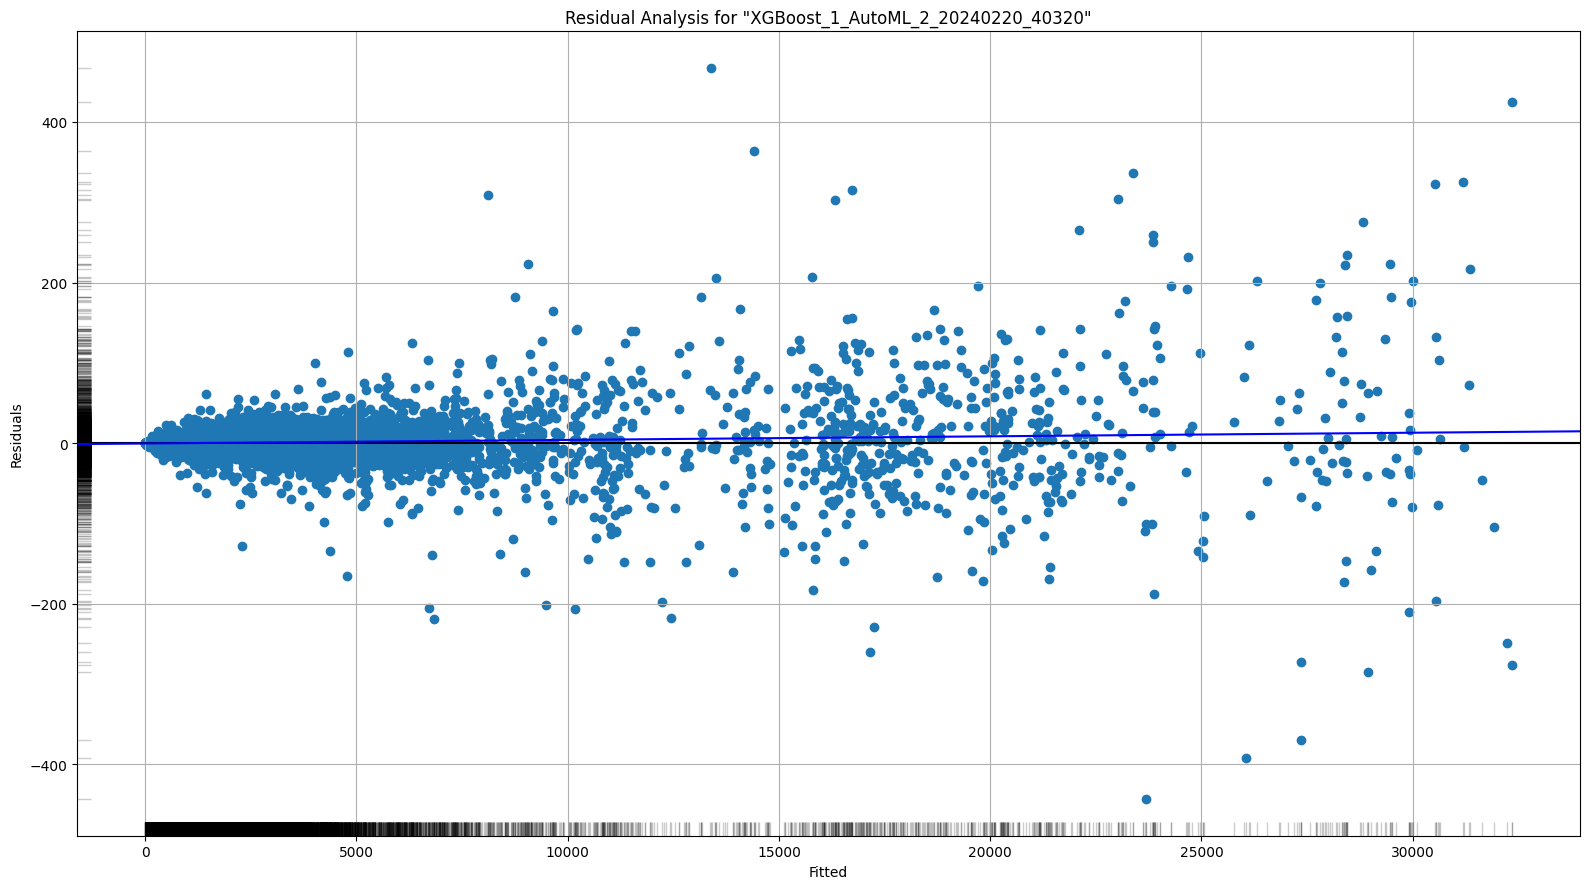

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

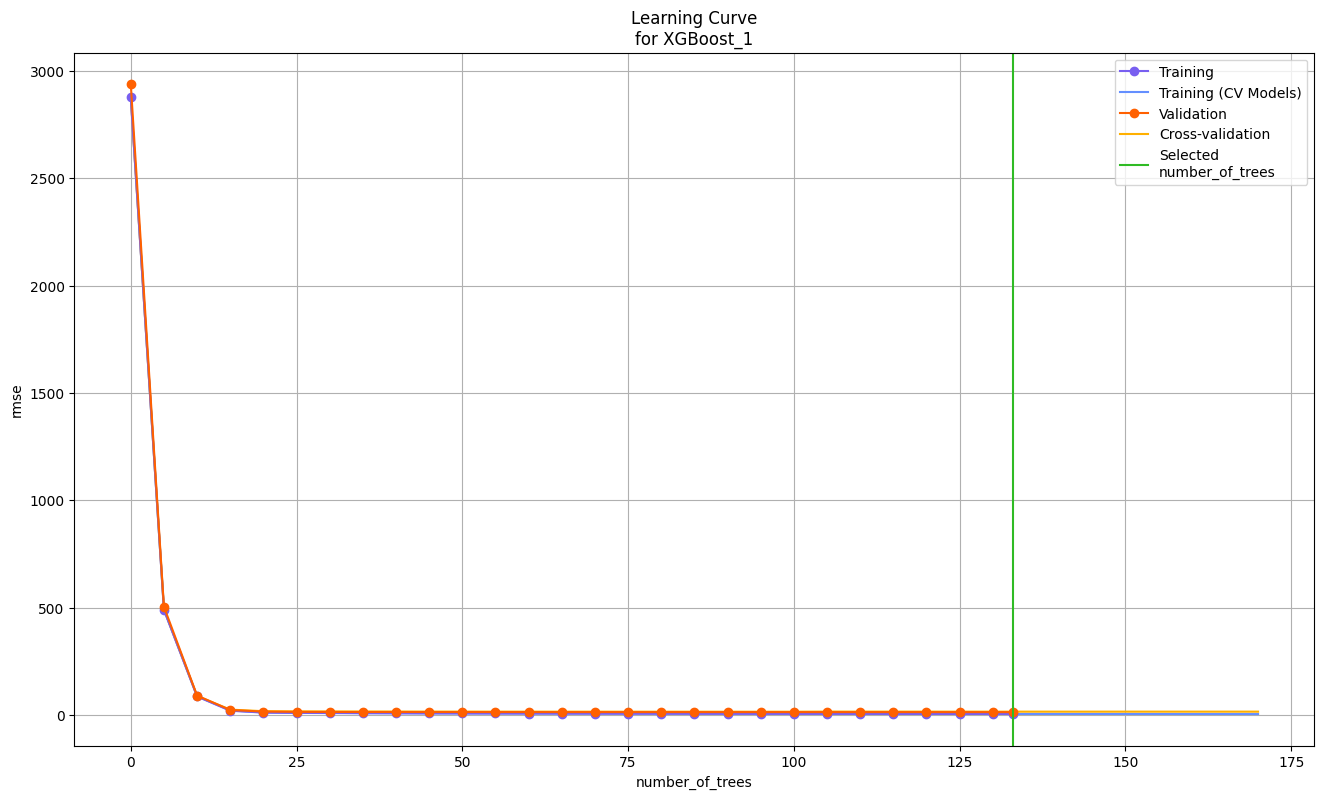

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

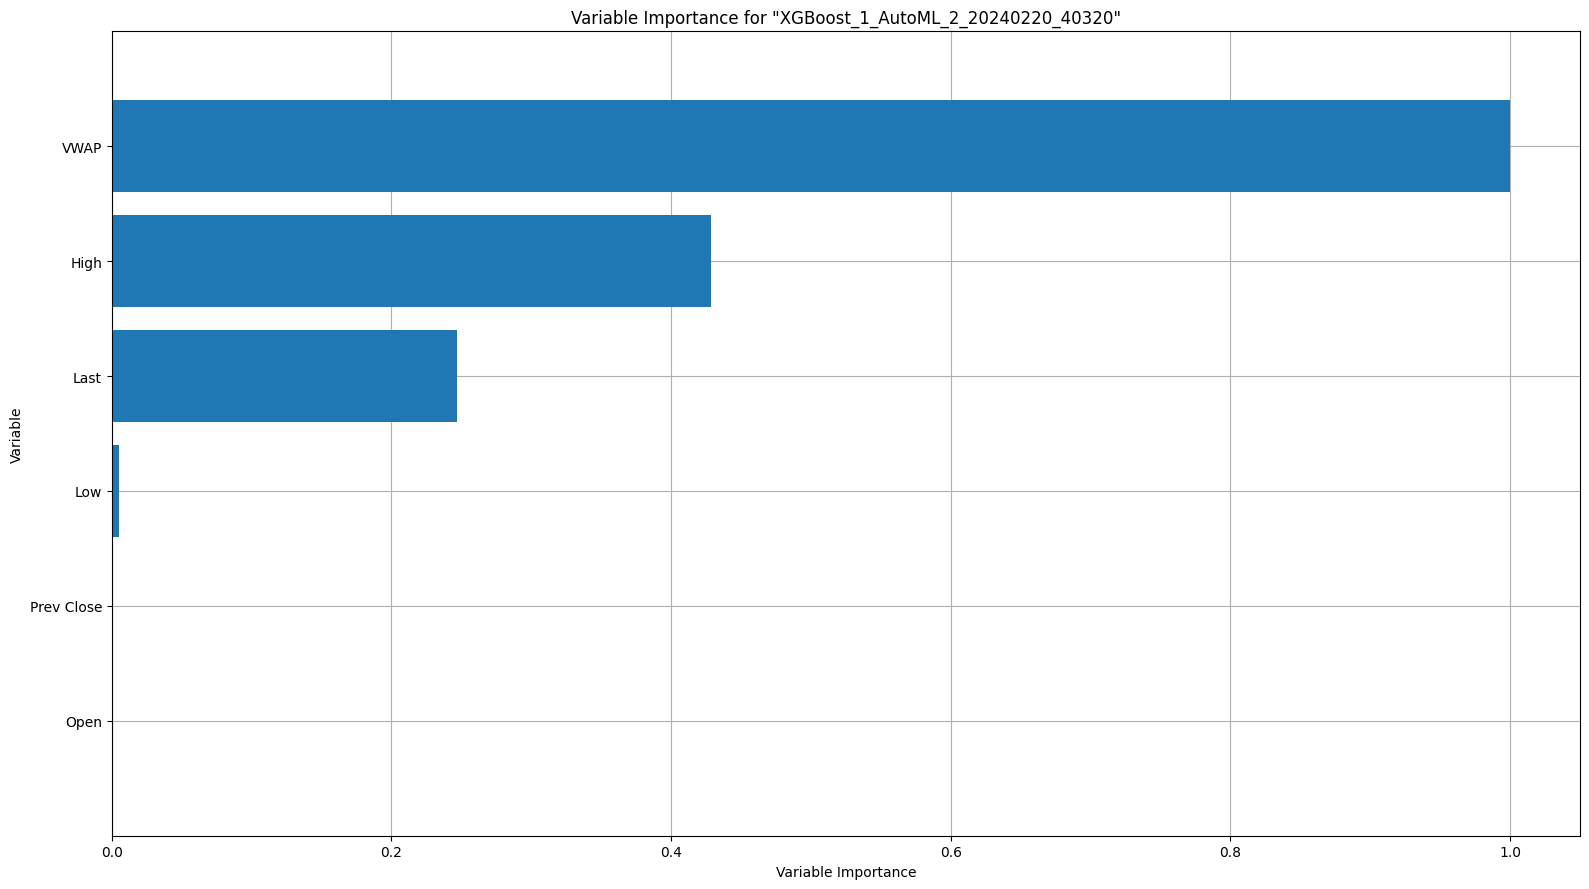

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

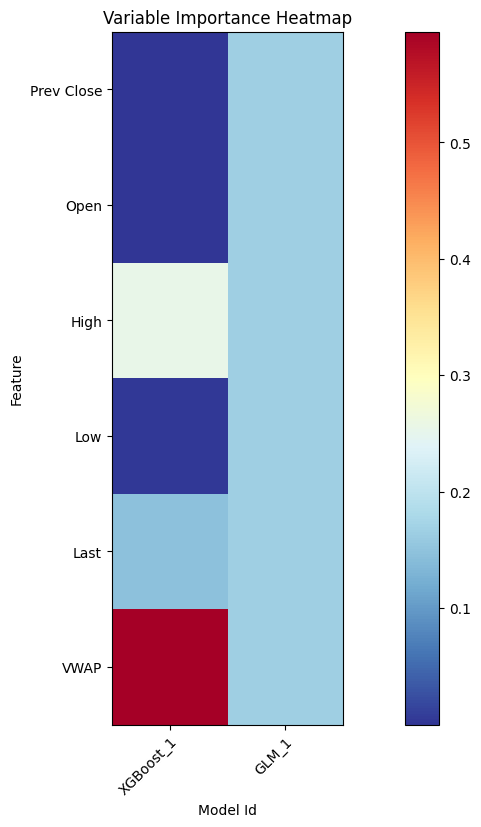

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

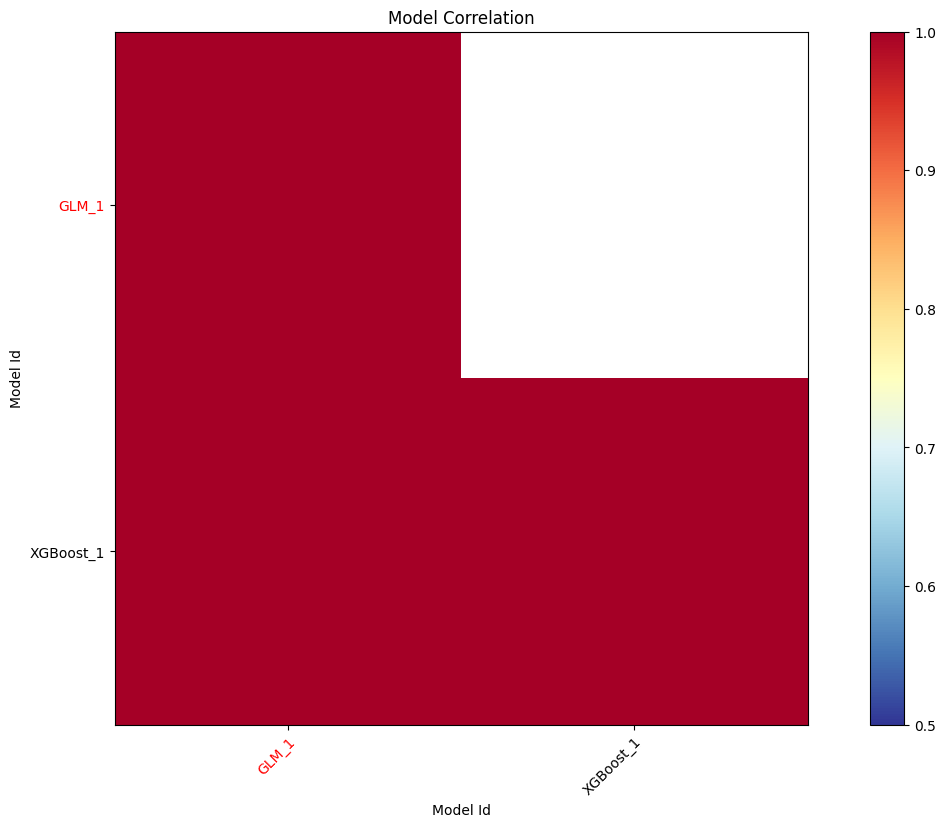

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

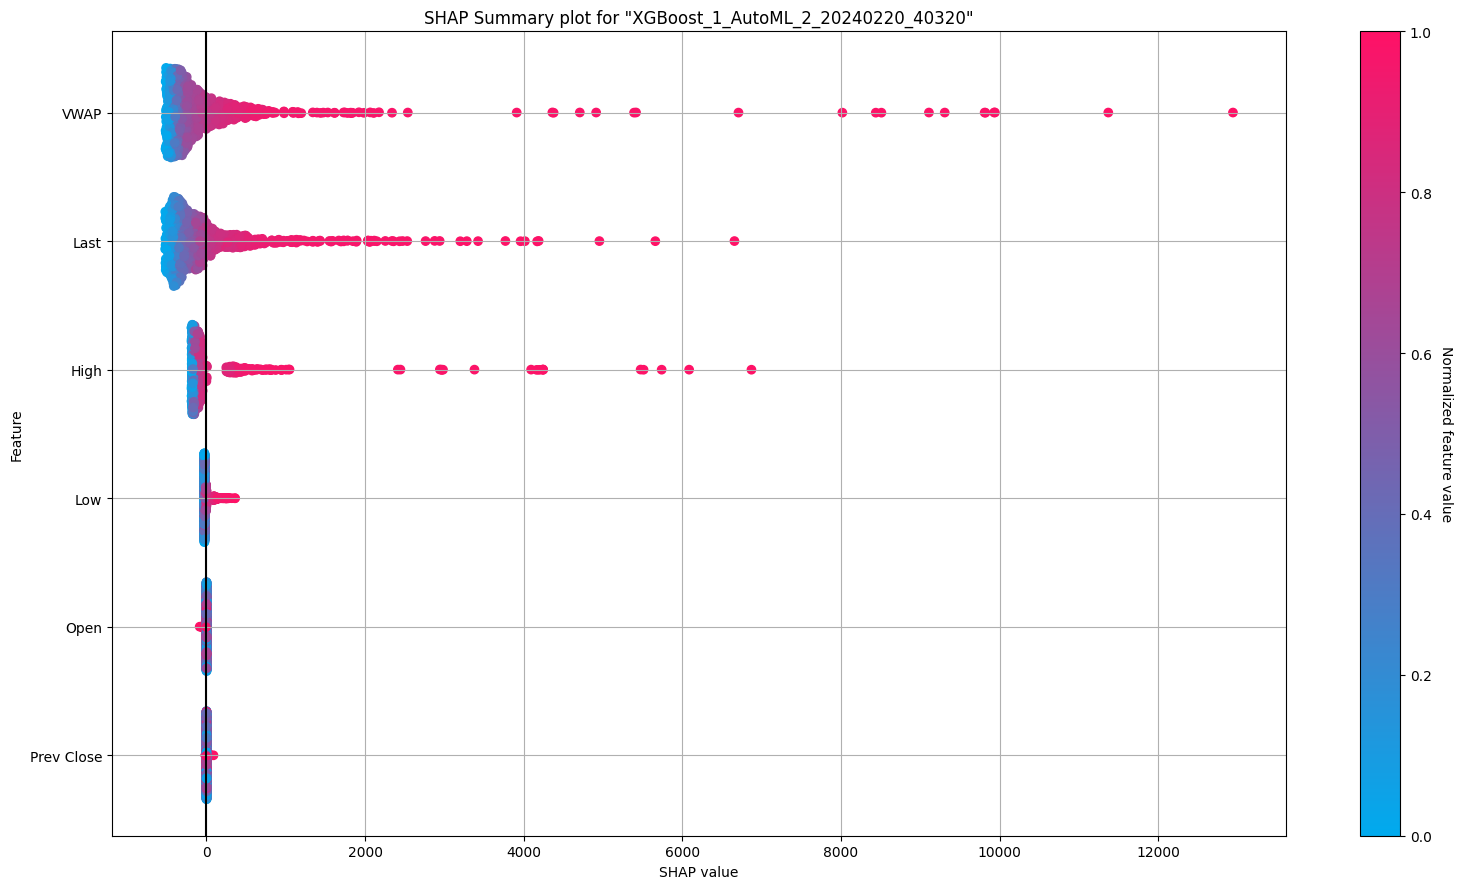

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

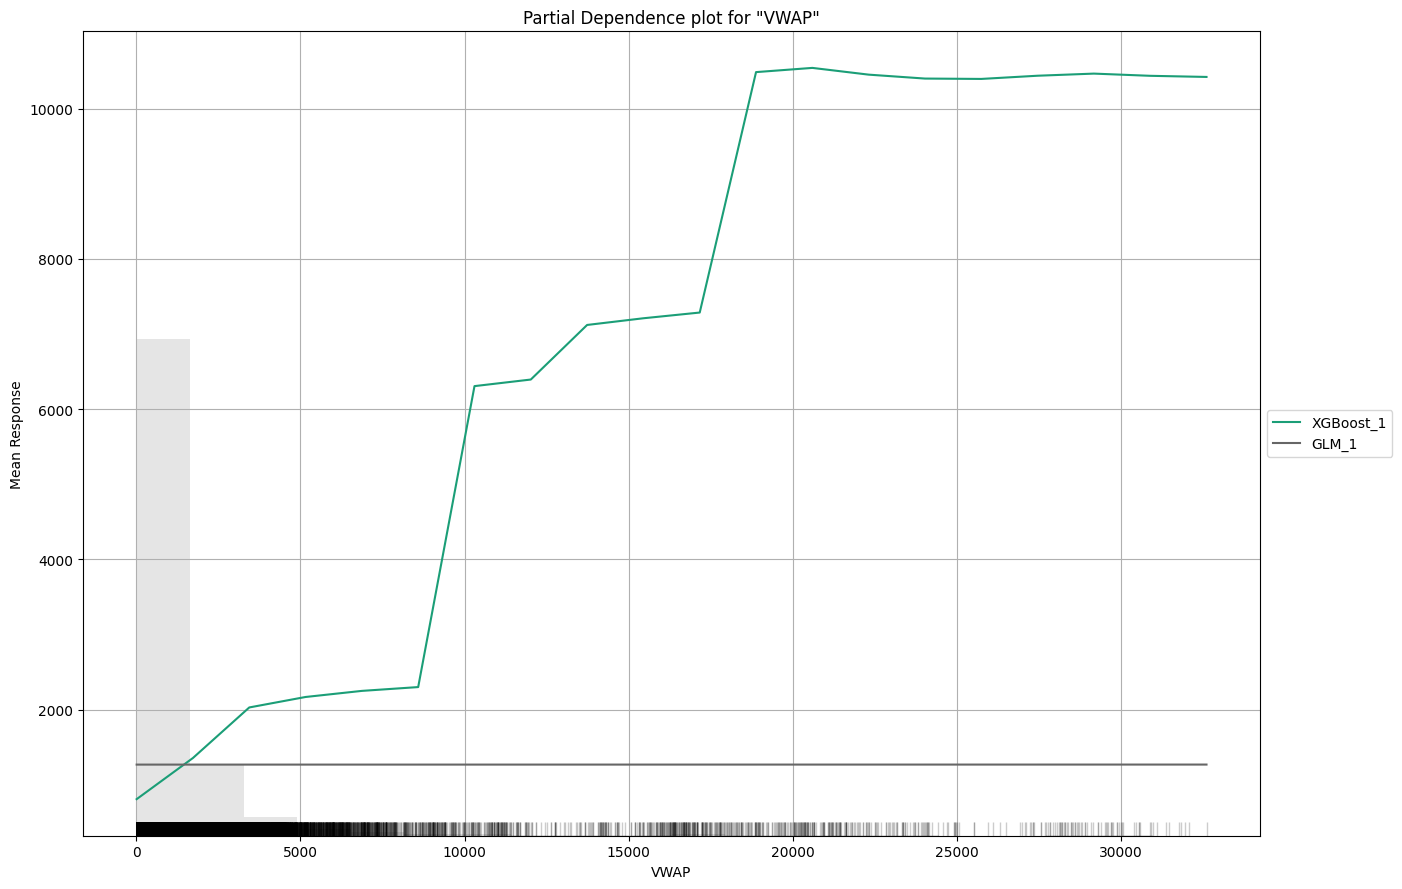

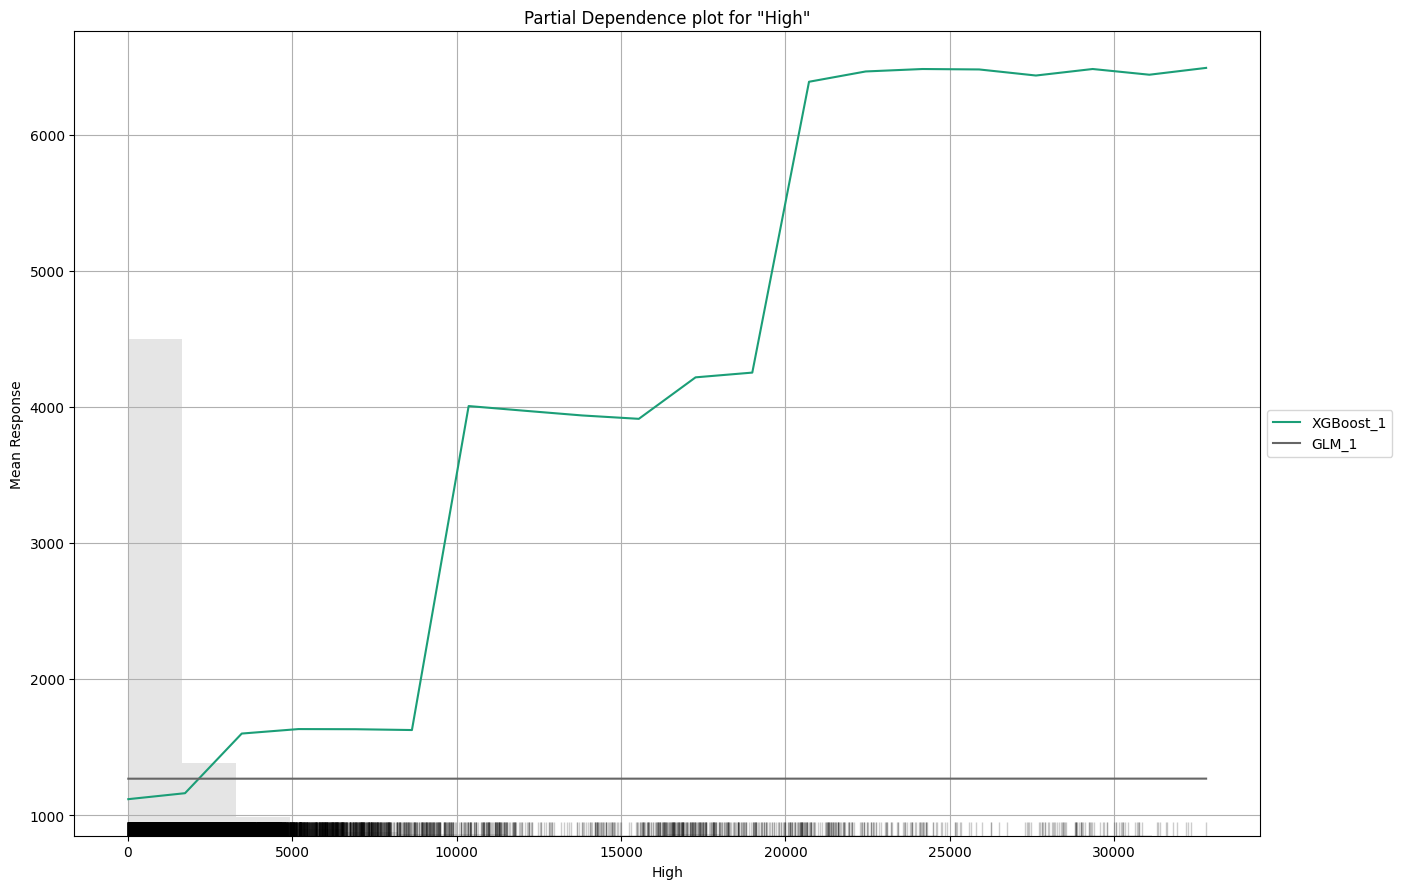

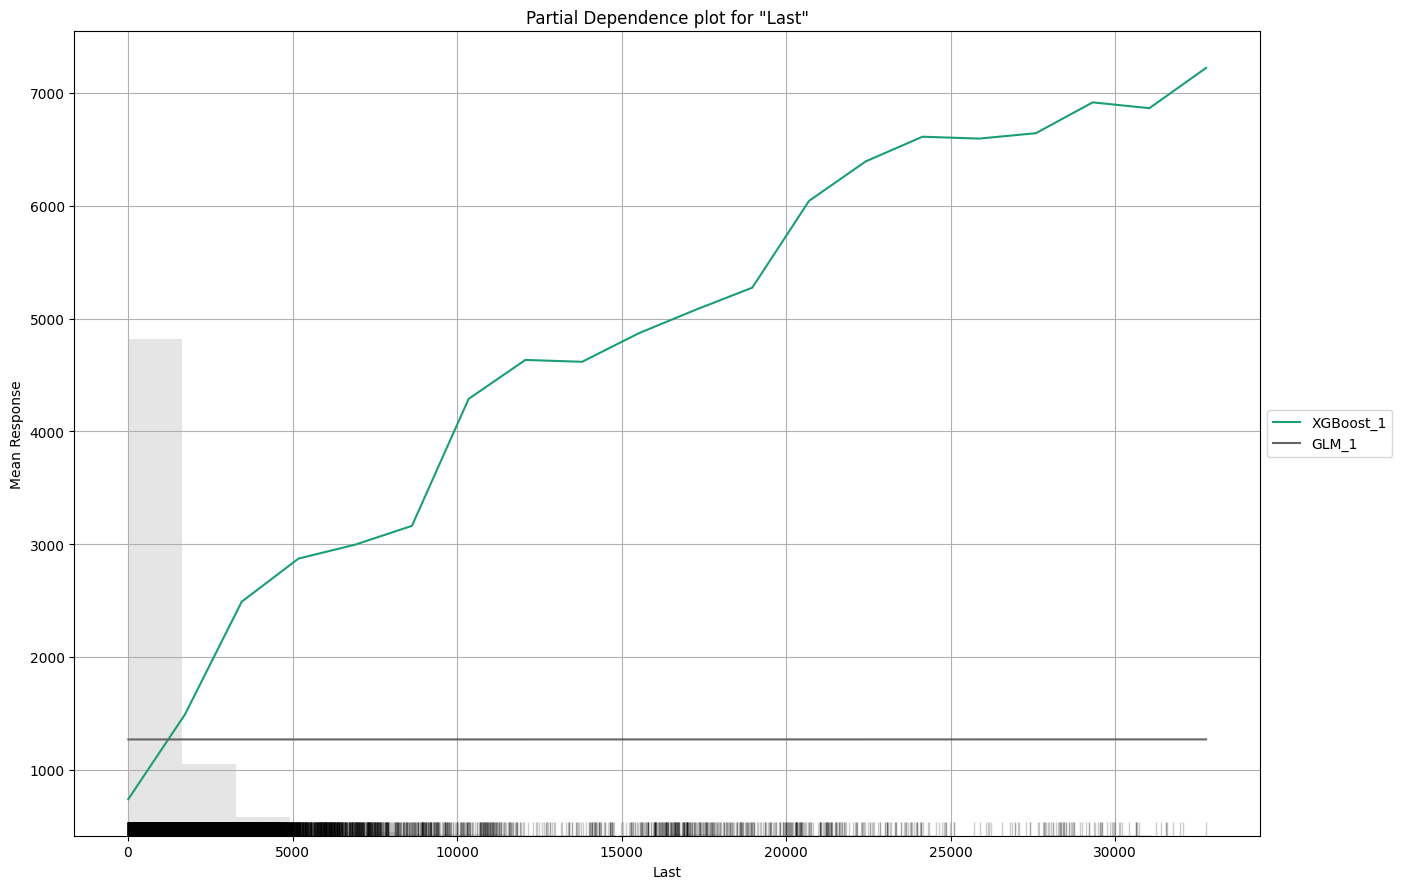

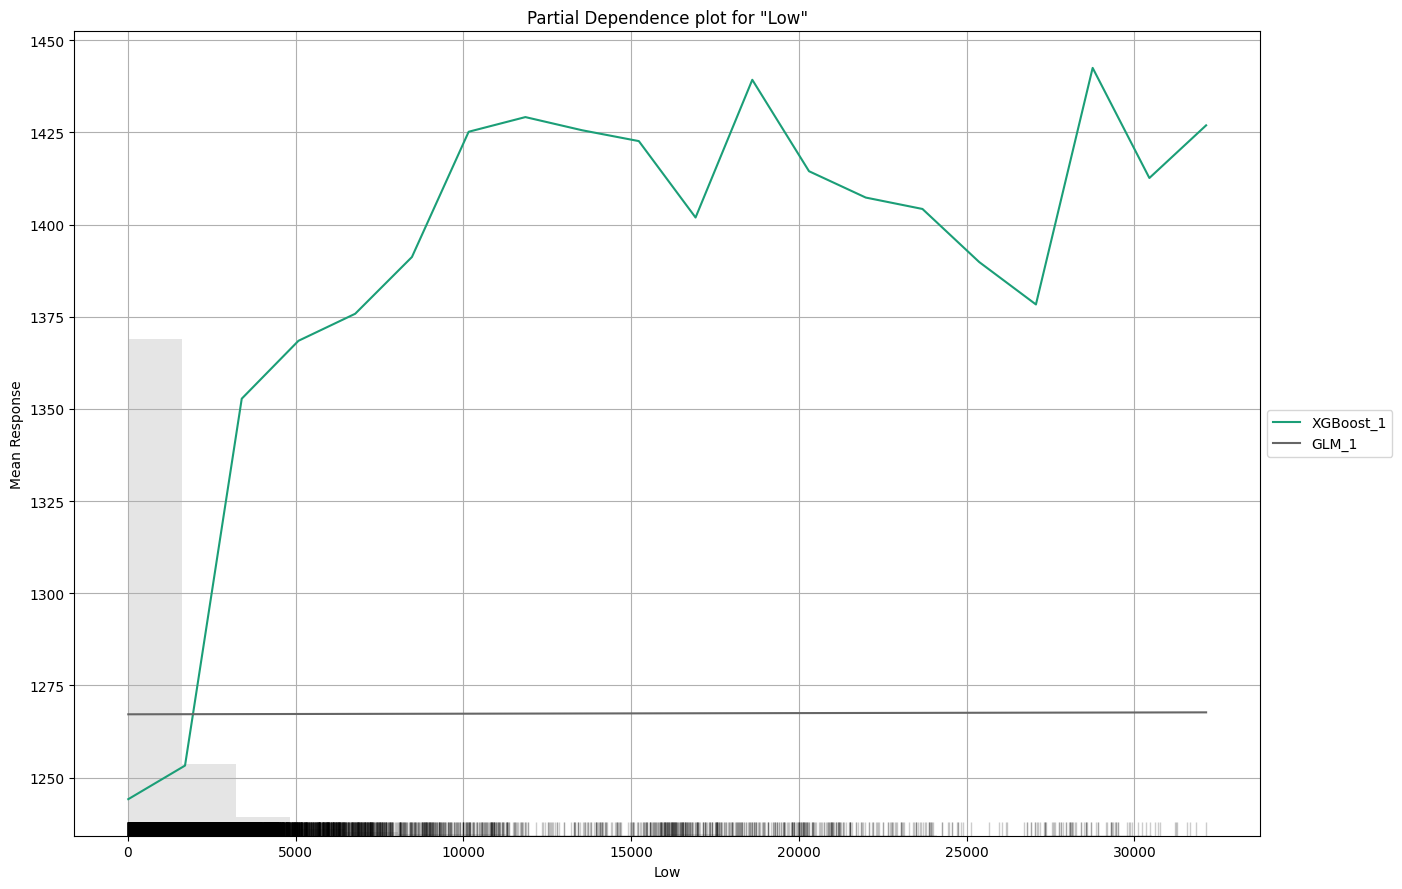

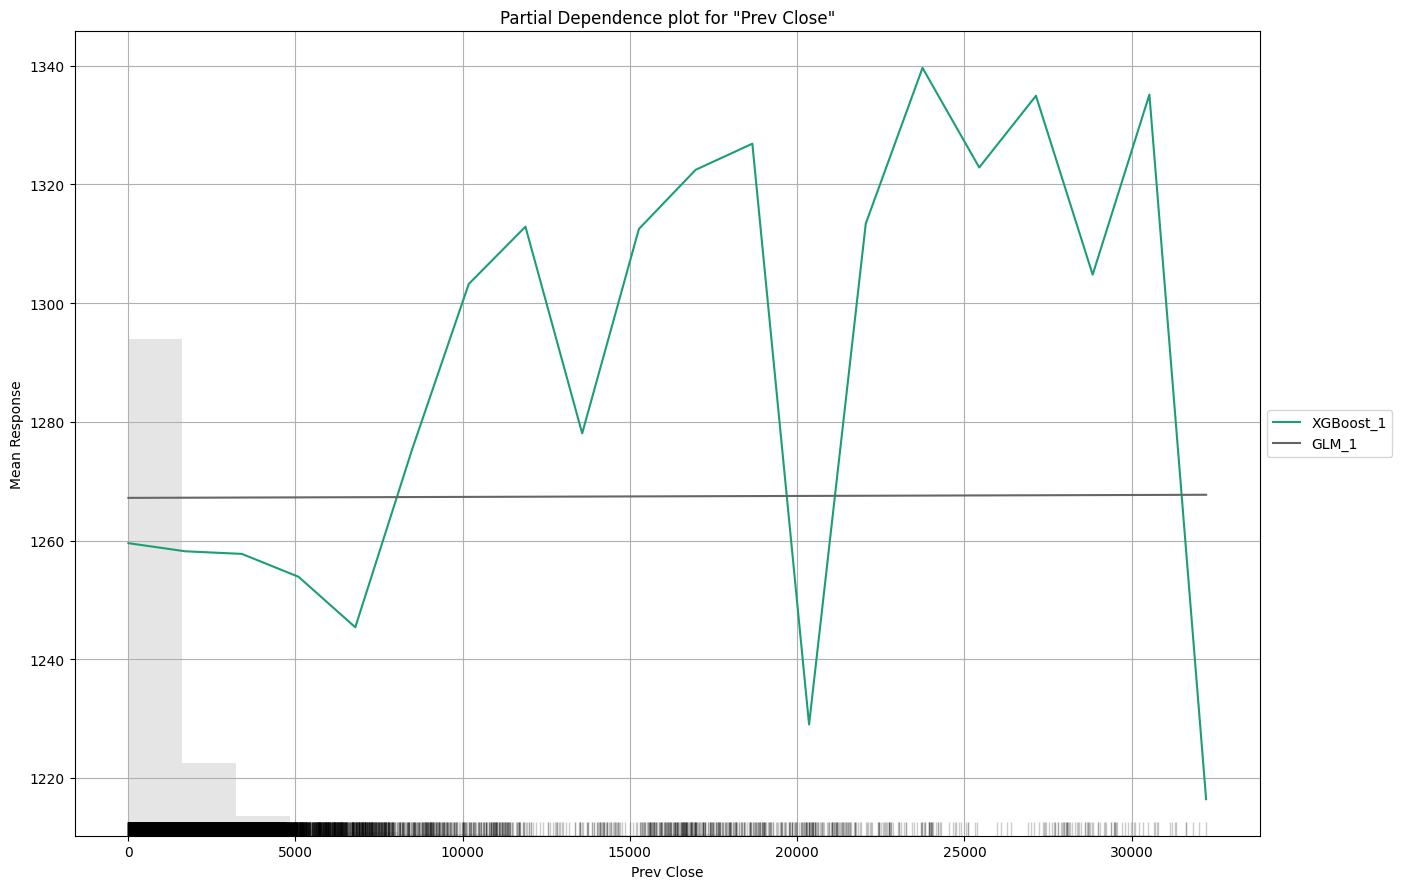

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

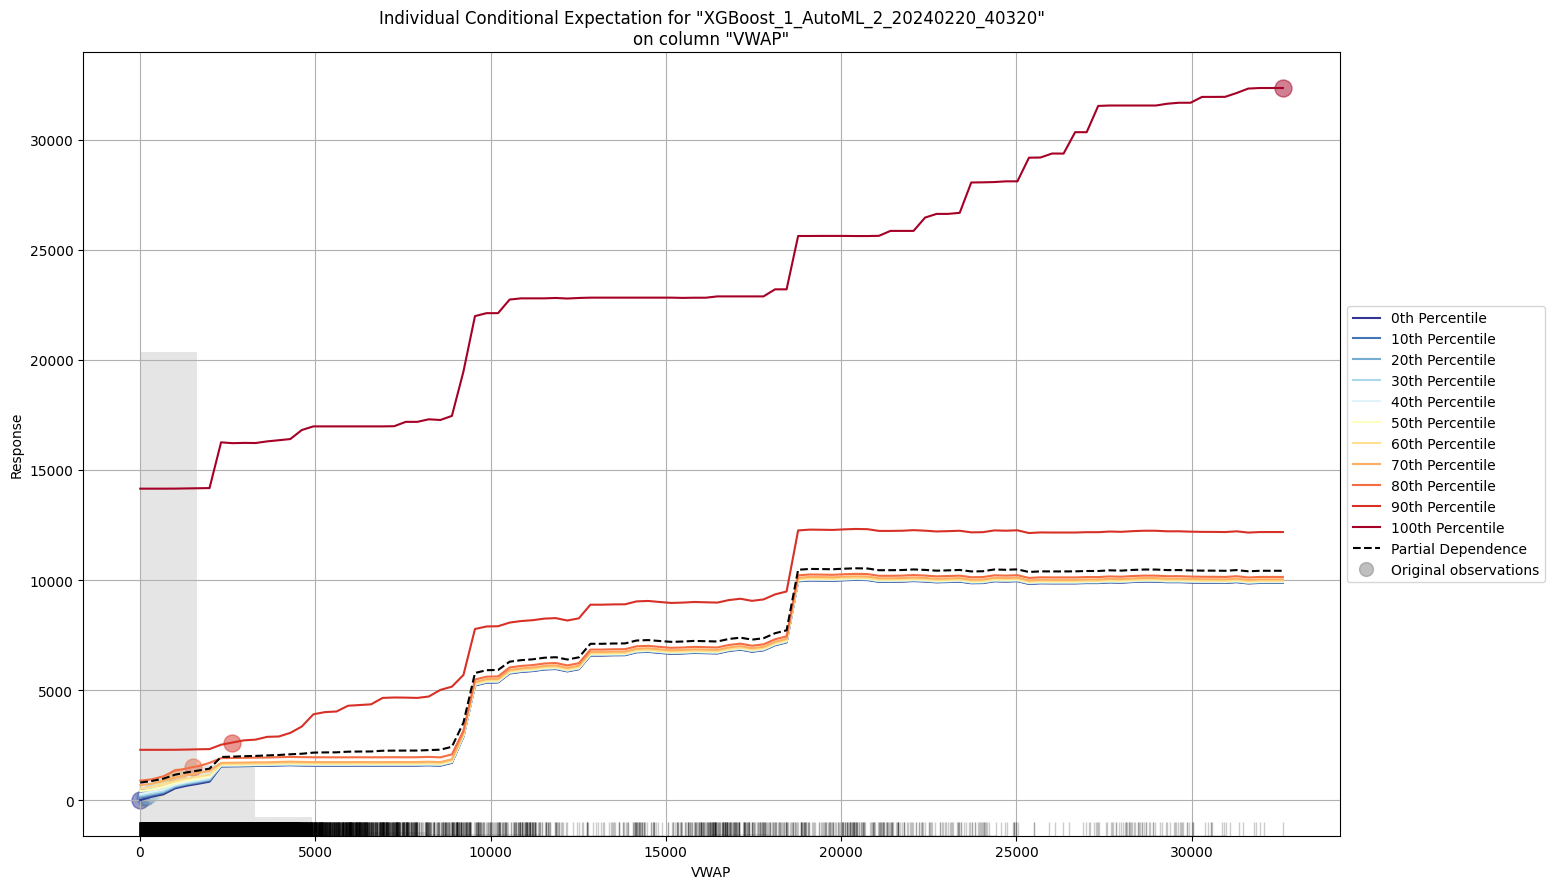

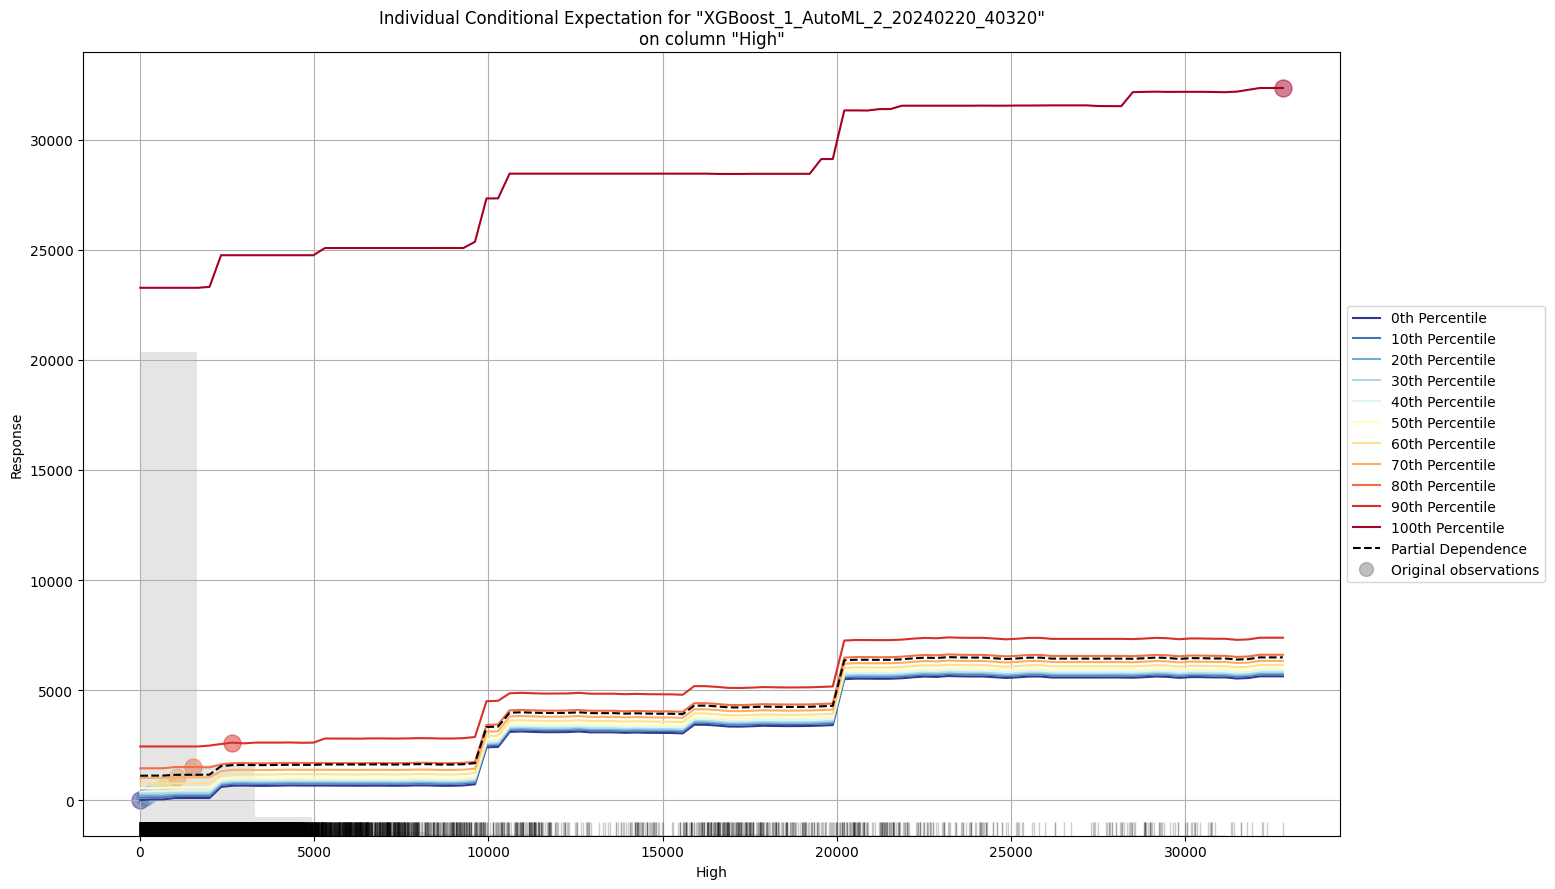

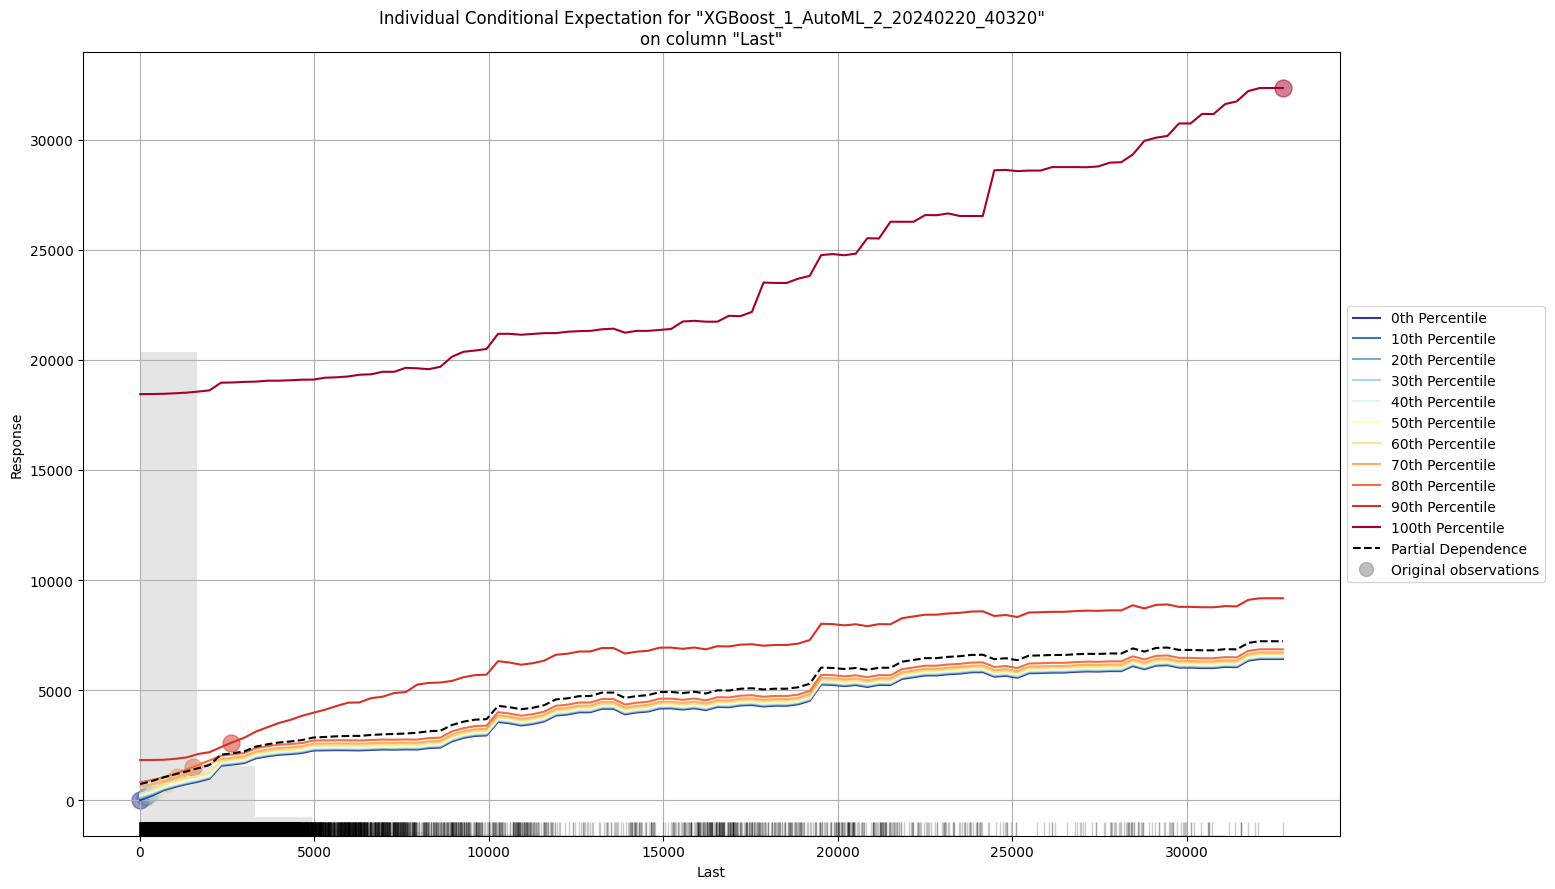

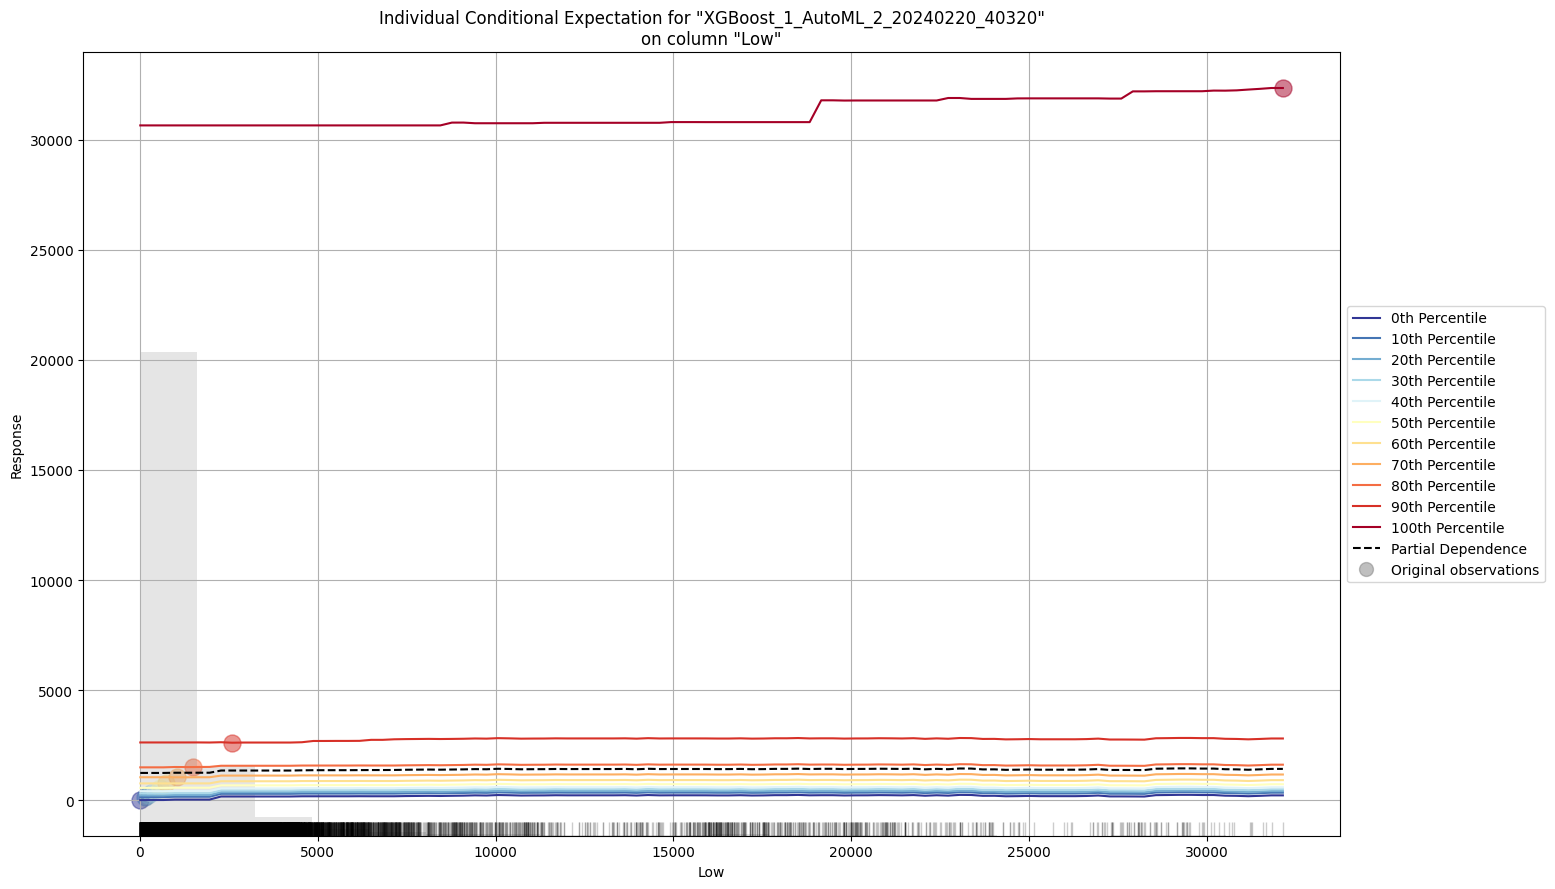

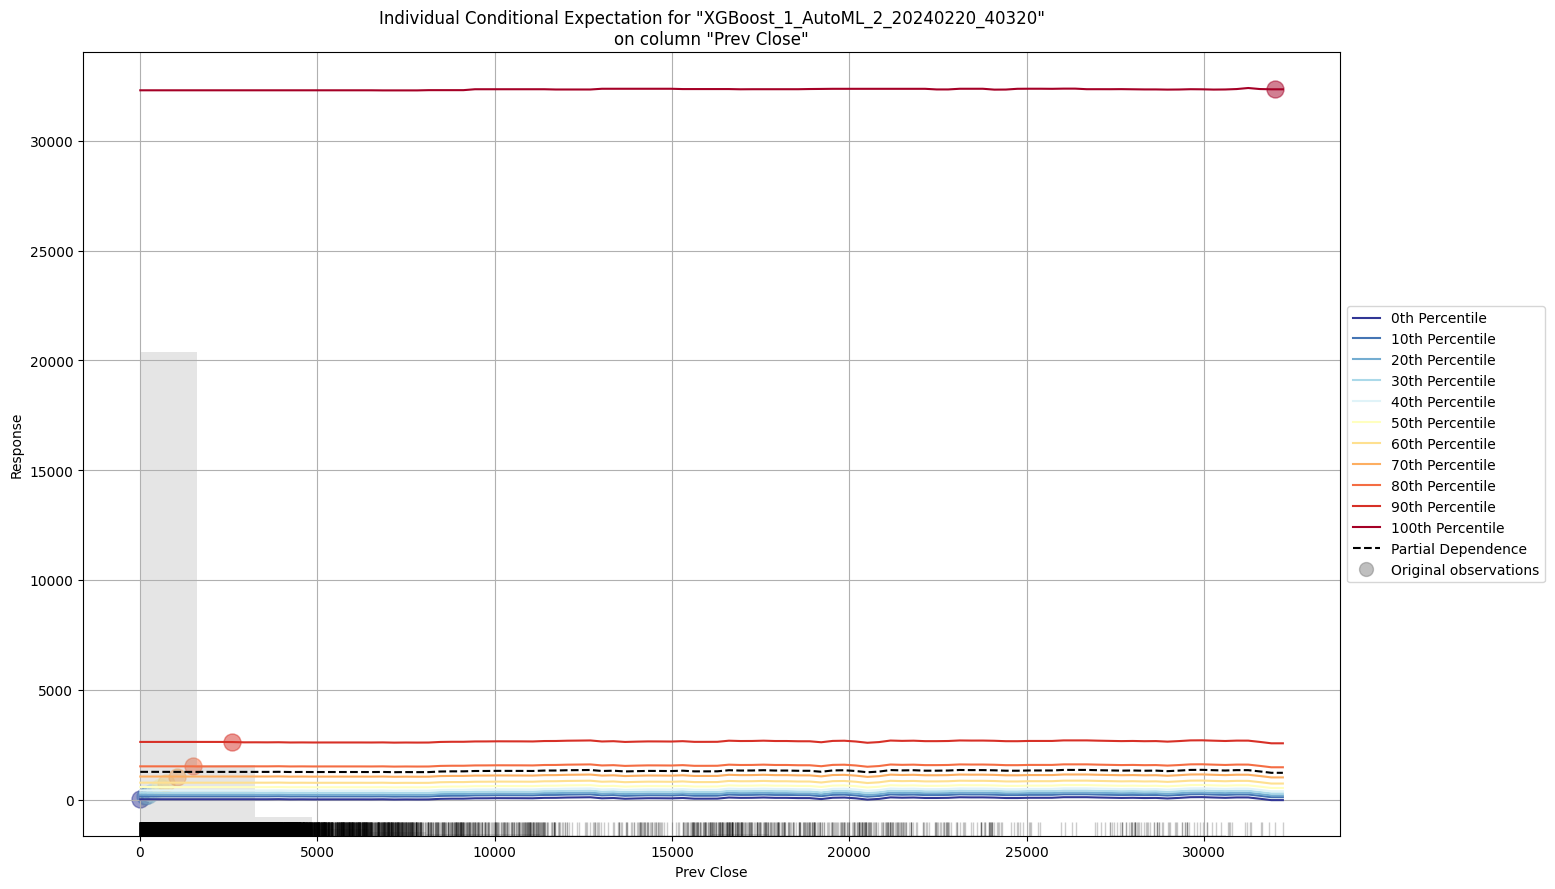

In [32]:
e = aml1.explain(test1)

# Observations after re-executing AutoML

* There is little improvement in the overall value of MAE (not very significant)
* The **Variable Importance** in addition to the previous featurs shows that **Low** also has low impact in prediction
* The **Variable Importance Heatmap** also shows that most of the features selected while re-training have little more impact on the predictor
* Rest of the plots show almost similar results with slight differences.

# Assumptions violation Check

In [33]:
#Seperating dependent and independent variable
A = data.drop(['Close'],axis=1)
B = data['Close']

In [34]:
#Splitting the data
A_train,A_test,b_train,b_test=train_test_split(A,B,test_size=0.2,random_state=42)

In [35]:
#Training the model
cols1 = ['Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP']
model1 = sm.OLS(b_train,sm.add_constant(A_train[cols1])).fit()

In [36]:
# To make prediction
b_pred = model1.predict(sm.add_constant(A_train[cols1]))

In [37]:
# Calculating the Mean of Residuals
residuals = b_train-b_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -5.120424282974782e-13


<ipython-input-38-29e35fe79c37>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  p = sns.distplot(residuals,kde=True)


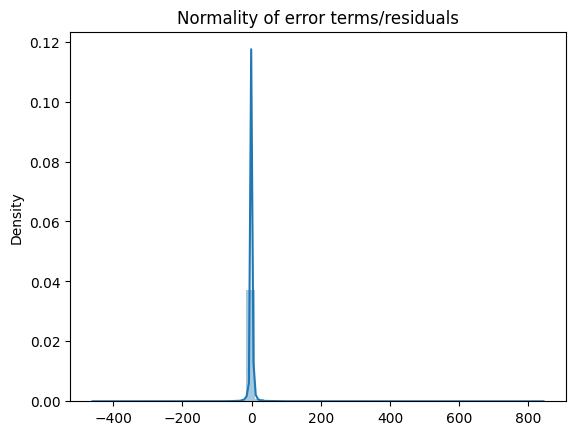

In [38]:
#The distribution
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

While plotting a distplot it should show normal distrubution which is shown in the above figure

# Trying Lasso Regularization

In [39]:
# Defining the Lasso regularization model
lasso = H2OGeneralizedLinearEstimator(alpha=1, # L1 regularization
                                      lambda_=0.01, # Regularization strength
                                      family='gaussian',
                                      interaction_pairs=None,
                                      lambda_search=False,
                                      seed=1234)
predictors = ['Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP']
response = 'Close'
# Training the model using the training set
lasso.train(x=predictors, y=response, training_frame=train1)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708400821646_7


GLM Model: summary
    family    link      regularization          number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ----------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Lasso (lambda = 0.01 )  6                             3                              1                       train

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 86.84238849068454
RMSE: 9.318926359333705
MAE: 2.779472482976268
RMSLE: 0.0038956343171278355
Mean Residual Deviance: 86.84238849068454
R^2: 0.999986975678225
Null degrees of freedom: 164728
Residual degrees of freedom: 164725
Null deviance: 1098365048167.6854
Residual deviance: 14305459.813681975
AIC: 1202856.5316750044

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective          training_rmse      training_deviance    training_mae       training_r2
--  -------------------  ----------  ------------  -------------------------  -----------------  -----------------  -------------------  -----------------  -----------------
    2024-02-20 04:19:17  0.000 sec   0             1098365048814.0122         6667709.078632251
    2024-02-20 04:19:17  0.163 sec   1                                                           9.318926359333705  86.84238849068454    2.779472482976268  0.999986975678225

Variable Importances: 
variable    relative_importance    scaled_importance    percentage
----------  ---------------------  -------------------  ------------
Last        1972.4                 1                    0.718805
VWAP        690.688                0.350176             0.251708
Open        80.9107                0.0410214            0.0294864
Prev Close  0                      0                    0
High        0                      0                    0
Low         0                      0                    0

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

From the above result we can see that the accuracy is similar before and after regularization i.e. the r2 value is close to 1. That means that regularization did not help in this case.

# Hyperparameter Tuning

In [40]:
# Defining the response and predictor variables
predictors = ['Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP']
response = 'Close'
# Defining the base model with default hyperparameters
base_model = H2ORandomForestEstimator(seed=1)

# Training the base model
base_model.train(x=predictors, y=response, training_frame=train1)

# Printing the base model metrics on the test set
print(base_model.model_performance(test1))

# Defining the hyperparameters to be tuned
hyper_params = {'ntrees': [50, 100, 150],
                'max_depth': [5, 10, 15],
                'min_rows': [5, 10, 15],
                'sample_rate': [0.6, 0.7, 0.8],
                'mtries': [2, 3, 4]}

# Defining the grid search criteria
search_criteria = {'strategy': 'RandomDiscrete',
                   'max_models': 10,
                   'seed': 1}

# Performing grid search
grid = H2OGridSearch(model=H2ORandomForestEstimator(seed=1234),
                     hyper_params=hyper_params,
                     search_criteria=search_criteria)

grid.train(x=predictors, y=response, training_frame=train, validation_frame=test)

# Printing the grid search results
print(grid.get_grid(sort_by='rmse', decreasing=False))

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
ModelMetricsRegression: drf
** Reported on test data. **

MSE: 145.0867260758608
RMSE: 12.045195144781209
MAE: 3.896954375168067
RMSLE: 0.035414129100522225
Mean Residual Deviance: 145.0867260758608
drf Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%
Hyper-Parameter Search Summary: ordered by increasing rmse
    max_depth    min_rows    mtries    ntrees    sample_rate    model_ids                                             rmse
--  -----------  ----------  --------  --------  -------------  ----------------------------------------------------  -------
    15           10          4         50        0.8            Grid_DRF_train_model_python_1708400821646_9_model_6   10.2288
    10           10          3         50        0.6            Grid_DRF_train_model_python_1708400821646_9_model_3   12.4265
    15           15          3         150       0.

In [41]:
# Retrieving the best model from the grid search
best_model = grid.get_grid(sort_by='rmse', decreasing=False)[0]

# Retrieving the values of the best hyperparameters
best_params = best_model.params

# Printing the values of the best hyperparameters
for param_name in best_params:
    param_value = best_params[param_name]['actual']
    print(f'{param_name}: {param_value}')

model_id: {'__meta': {'schema_version': 3, 'schema_name': 'ModelKeyV3', 'schema_type': 'Key<Model>'}, 'name': 'Grid_DRF_train_model_python_1708400821646_9_model_6', 'type': 'Key<Model>', 'URL': '/3/Models/Grid_DRF_train_model_python_1708400821646_9_model_6'}
training_frame: {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'train', 'type': 'Key<Frame>', 'URL': '/3/Frames/train'}
validation_frame: {'__meta': {'schema_version': 3, 'schema_name': 'FrameKeyV3', 'schema_type': 'Key<Frame>'}, 'name': 'test', 'type': 'Key<Frame>', 'URL': '/3/Frames/test'}
nfolds: 0
keep_cross_validation_models: True
keep_cross_validation_predictions: False
keep_cross_validation_fold_assignment: False
score_each_iteration: False
score_tree_interval: 0
fold_assignment: None
fold_column: None
response_column: {'__meta': {'schema_version': 3, 'schema_name': 'ColSpecifierV3', 'schema_type': 'VecSpecifier'}, 'column_name': 'Close', 'is_member_of_frames': None}
ignor

#Derivation:
The key parameters utilized for the Random Forest model include ntrees (number of trees), max_depth (maximum depth of each tree), min_rows (minimum number of observations required to create a new split), sample_rate (sampling rate for rows), and mtries (number of variables randomly sampled as candidates at each split). These parameters are crucial for controlling the complexity and performance of the model.

# 1. Is the relationship significant?
Based on our analysis, there appears to be a significant relationship between the independent variables and the close price. This is supported by the high R-squared values we obtained in our models and the low root mean squared error (RMSE) values in our models.

# 2. Are any model assumptions violated?
We tested for assumptions of linear regression and the assumptions are not voilated, there is a normal distribution as shown above

# 3. Is there any multicollinearity in the model?
Based on our correlation analysis, some of the independent variables had high correlations with each other thereby indicating the presence of multicollinearity.

# 4. In the multivariate models are predictor variables independent of all the other predictor variables?
Based on our analysis, there were some independent variables that had high correlations with each other, indicating that they were not completely independent.

# 5. In the multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.
Based on our analysis, some of the most significant predictor variables were [ 'High', 'Low', 'Last', 'VWAP', 'Prev Close,', 'Open']

# 6. Does the model make sense?
Based on our analysis the Models make sense, the independent variables were related to the dependent variable. And the 2 models that we saw trained using H2o had decent results and were showing the relation between variables.

# 7. Does regularization help?
Since there was no significant change in the model result after the Lasso regularization, our analysis states that regularization does not help in our case.

# 8. Which independent variables are significant?
 [ 'High', 'Low', 'Last', 'VWAP'] are the independent variables that are significant based on our analysis.

# 9. Which hyperparameters are important?
Important hyperparameters include ntrees, max_depth, min_rows, sample_rate, and mtries, based on our analysis in hyper parameter tuning.

# 10. Coding professionalism?
Yes, professionalism was maintained throughout the coding process.

# Conclusion
In conclusion, we have performed AutoML using H2O library on the Stock dataset. We used various algorithms to predict the close price of stock on its features.

After evaluating the models using various metrics, we found that the H2O AutoML model with regularization and without regularization provided a similar performance. The most significant predictor variables in the final model were 'High', 'Last', 'Low', 'VWAP'.

We also found that there was no violation of model assumptions, and multicollinearity was not a significant issue.

Overall, in all the models returned by AutoML we observed that there was similar performance and the MAE was set as the deciding factor in the best model given that all the models make sense.

References :

https://github.com/nikbearbrown

https://matplotlib.org/stable/

https://plotly.com/

https://seaborn.pydata.org/

https://scikit-learn.org/stable/

https://www.statsmodels.org/stable/index.html

https://pandas.pydata.org/docs/user_guide/index.html#user-guide

https://github.com/aiskunks/YouTube/tree/main/A_Crash_Course_in_Statistical_Learning/AutoML

https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/_modules/index.html




https://chat.openai.com/ (for help in commenting and writing concise conclusions)

MIT License

Copyright (c) 2024 Anusha Gali

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.